# Importing Libraries

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from xgboost import XGBRegressor
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from scipy.stats import zscore, ttest_ind, f_oneway, chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_predict

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

_ = plt.figure(figsize=(20, 10))

<Figure size 2000x1000 with 0 Axes>

# Uploading dataset

In [ ]:
from google.colab import files
files.upload()

Saving insurance.csv to insurance.csv


{'insurance.csv': b'Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice\r\n45,0,0,0,0,155,57,0,0,0,25000\r\n60,1,0,0,0,180,73,0,0,0,29000\r\n36,1,1,0,0,158,59,0,0,1,23000\r\n52,1,1,0,1,183,93,0,0,2,28000\r\n38,0,0,0,1,166,88,0,0,1,23000\r\n30,0,0,0,0,160,69,1,0,1,23000\r\n33,0,0,0,0,150,54,0,0,0,21000\r\n23,0,0,0,0,181,79,1,0,0,15000\r\n48,1,0,0,0,169,74,1,0,0,23000\r\n38,0,0,0,0,182,93,0,0,0,23000\r\n60,0,1,0,0,175,74,0,0,2,28000\r\n66,1,0,0,0,186,67,0,0,0,25000\r\n24,0,0,0,0,178,57,1,0,1,15000\r\n46,0,1,0,0,184,97,0,0,0,35000\r\n18,0,0,1,0,150,76,0,0,1,15000\r\n38,0,0,0,0,160,68,1,0,1,23000\r\n42,0,0,0,1,149,67,0,0,0,30000\r\n38,1,0,0,0,154,82,0,0,0,23000\r\n57,1,0,0,0,156,61,0,0,0,25000\r\n21,0,1,0,0,186,97,0,0,0,15000\r\n49,1,0,0,0,160,97,0,0,2,28000\r\n20,1,0,0,0,181,81,0,0,0,15000\r\n35,0,0,0,0,163,92,0,0,1,32000\r\n35,0,1,0,0,175,83,0,0,1,23000\r\n53,0,1,0,0,151,97,0,1,1,350

# Reading dataset

In [ ]:
def read_data():
  df = pd.read_csv('insurance.csv')
  df.rename(columns={
      'Age'                     : 'age',
      'Diabetes'                : 'diabetes',
      'BloodPressureProblems'   : 'blood_pressure_problems',
      'AnyTransplants'          : 'any_transplants',
      'AnyChronicDiseases'      : 'any_chronic_diseases',
      'Height'                  : 'height',
      'Weight'                  : 'weight',
      'KnownAllergies'          : 'known_allergies',
      'HistoryOfCancerInFamily' : 'history_of_cancer_in_family',
      'NumberOfMajorSurgeries'  : 'number_of_major_surgeries',
      'PremiumPrice'            : 'premium_price'
  }, inplace=True)

  return df

df = read_data()

df.head()

,age,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,height,weight,known_allergies,history_of_cancer_in_family,number_of_major_surgeries,premium_price
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


# Feature Engineering

In [ ]:
def overall_risk_category(row):
  risk_score = 0
  risk_score += row['age'] > 50  # Age factor
  risk_score += row['bmi'] > 30  # Obesity
  risk_score += row['health_score'] >= 3  # Multiple conditions
  risk_score += row['any_transplants']  # High risk condition
  risk_score += row['number_of_major_surgeries'] >= 2  # Multiple surgeries

  if risk_score >= 4:
      return 'critical'
  elif risk_score >= 3:
      return 'high'
  elif risk_score >= 2:
      return 'medium'
  else:
      return 'low'

def bmi_category(bmi):
  if bmi < 18.5:
      return 'underweight'
  elif bmi < 25:
      return 'normal'
  elif bmi < 30:
      return 'overweight'
  else:
      return 'obese'

def create_features(df):
  # Creating Body Mass Index feature from Height and Weight
  # This estimates the body fat percentage of the individual
  df['bmi'] = np.round(df['weight'] / ((df['height'] / 100) ** 2), 2)

  # Age groups
  # Seperating age makes it easier to infer analysis
  bins = [17, 25, 35, 45, 55, 66]
  labels = [1, 2, 3, 4, 5]
  df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

  # Total Health issues
  # This provides the complete information of health condition
  # based on the given information
  health_issues = ['diabetes', 'blood_pressure_problems', 'any_transplants',
                  'any_chronic_diseases', 'known_allergies',
                  'history_of_cancer_in_family']
  df['health_score'] = df[health_issues].sum(axis=1)

  # Age, Health Score, Surgeries interaction
  # Since its a multiplicative term, it can give the complexity
  # of the health profile
  # A high value could indicate a potentially high risk individual
  df['age_health_surgery'] = np.round(df['age'] *
                                      df['health_score'] *
                                      df['number_of_major_surgeries'], 3)

  # Surgery Per Age
  # This provides an information where people had more surgeries in early stage or not
  # indicating a spike in premiums based on the situation
  df['surgery_per_age'] = np.round(df['number_of_major_surgeries'] / df['age'], 2)

  df['age_bmi_interaction'] = df['age'] * df['bmi']
  df['bmi_health_interaction'] = df['bmi'] * df['health_score']

  df['age_squared'] = df['age'] ** 2
  df['overall_risk_category'] = df.apply(overall_risk_category, axis=1)
  df['bmi_category'] = df['bmi'].apply(bmi_category)

  df['high_cost_condition'] = ((df['any_transplants'] == 1) |
                                (df['history_of_cancer_in_family'] == 1)).astype(int)

  df['metabolic_syndrome_proxy'] = ((df['diabetes'] == 1) &
                                    (df['blood_pressure_problems'] == 1) &
                                    (df['bmi'] > 30)).astype(int)

  df['risk_density'] = df['health_score'] / df['age']

  return df

In [ ]:
# Final Data

df = create_features(df)
df.head()

,age,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,height,weight,known_allergies,history_of_cancer_in_family,number_of_major_surgeries,premium_price,bmi,age_group,health_score,age_health_surgery,surgery_per_age,age_bmi_interaction,bmi_health_interaction,age_squared,overall_risk_category,bmi_category,high_cost_condition,metabolic_syndrome_proxy,risk_density
0,45,0,0,0,0,155,57,0,0,0,25000,23.73,3,0,0,0.00,1067.85,0.00,2025,low,normal,0,0,0.000000
1,60,1,0,0,0,180,73,0,0,0,29000,22.53,5,1,0,0.00,1351.80,22.53,3600,low,normal,0,0,0.016667
2,36,1,1,0,0,158,59,0,0,1,23000,23.63,3,2,72,0.03,850.68,47.26,1296,low,normal,0,0,0.055556
3,52,1,1,0,1,183,93,0,0,2,28000,27.77,4,3,312,0.04,1444.04,83.31,2704,high,overweight,0,0,0.057692
4,38,0,0,0,1,166,88,0,0,1,23000,31.93,3,1,38,0.03,1213.34,31.93,1444,low,obese,0,0,0.026316


# Exploratory Data Analysis

## Data Description

In [ ]:
# Shape of data

rows, cols = df.shape
print(f'Number of rows : {rows}')
print(f'Number of columns : {cols}')

Number of rows : 986
Number of columns : 24


In [ ]:
# Converting column data types

cols = ['diabetes', 'blood_pressure_problems', 'any_transplants',
        'any_chronic_diseases', 'known_allergies', 'history_of_cancer_in_family',
        'age_group', 'health_score']

for col in cols:
  df[col] = df[col].astype('category')

df['premium_price'] = df['premium_price'].astype(float)
df['bmi'] = df['bmi'].astype(float)

In [ ]:
# Column Data types
df.dtypes

,0
age,int64
diabetes,category
blood_pressure_problems,category
any_transplants,category
any_chronic_diseases,category
height,int64
weight,int64
known_allergies,category
history_of_cancer_in_family,category
number_of_major_surgeries,int64


In [ ]:
# Numerical data description
df.describe()

,age,height,weight,number_of_major_surgeries,premium_price,bmi,age_health_surgery,surgery_per_age,age_bmi_interaction,bmi_health_interaction,age_squared,high_cost_condition,metabolic_syndrome_proxy,risk_density
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,168.182556,76.950304,0.667343,24336.713996,27.460639,58.826572,0.015588,1142.911207,39.848316,1937.459432,0.168357,0.063895,0.037420
std,13.963371,10.098155,14.265096,0.749205,6248.184382,5.878789,89.110035,0.016977,454.096570,28.549511,1185.599860,0.374373,0.244689,0.029488
min,18.000000,145.000000,51.000000,0.000000,15000.000000,15.160000,0.000000,0.000000,325.090000,0.000000,324.000000,0.000000,0.000000,0.000000
25%,30.000000,161.000000,67.000000,0.000000,21000.000000,23.395000,0.000000,0.000000,782.445000,22.840000,900.000000,0.000000,0.000000,0.018182
50%,42.000000,168.000000,75.000000,1.000000,23000.000000,27.155000,0.000000,0.020000,1099.960000,35.040000,1764.000000,0.000000,0.000000,0.033898
75%,53.000000,176.000000,87.000000,1.000000,28000.000000,30.760000,95.500000,0.030000,1427.652500,58.605000,2809.000000,0.000000,0.000000,0.050000
max,66.000000,188.000000,132.000000,3.000000,40000.000000,50.000000,456.000000,0.060000,2850.000000,153.560000,4356.000000,1.000000,1.000000,0.166667


In [ ]:
# Categorical data description
df.describe(include='category')

,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,known_allergies,history_of_cancer_in_family,age_group,health_score
count,986,986,986,986,986,986,986,986
unique,2,2,2,2,2,2,5,6
top,0,0,0,0,0,0,2,1
freq,572,524,931,808,774,870,210,350


In [ ]:
# Null Value count

df.isnull().sum()

,0
age,0
diabetes,0
blood_pressure_problems,0
any_transplants,0
any_chronic_diseases,0
height,0
weight,0
known_allergies,0
history_of_cancer_in_family,0
number_of_major_surgeries,0


In [ ]:
# Duplicated data count
print(f'Number of duplicated rows : {int(df.duplicated().sum())}')

Number of duplicated rows : 0


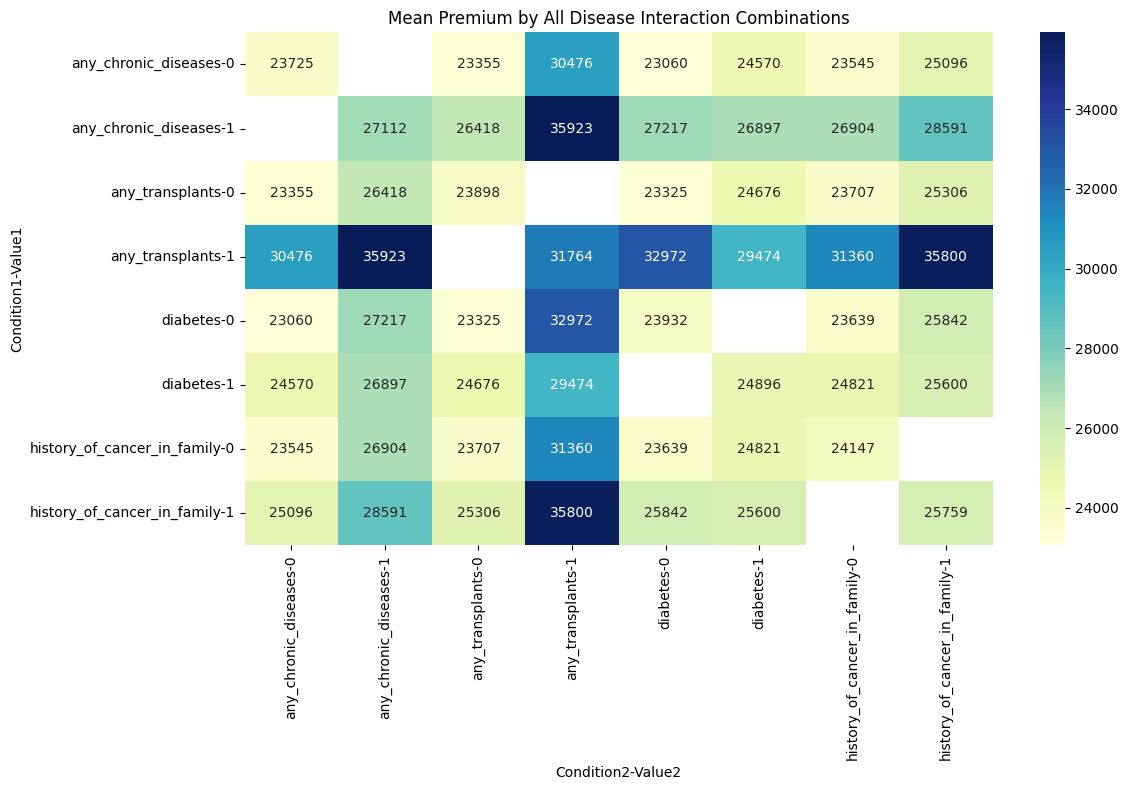

In [ ]:
disease_cols = ['diabetes', 'any_chronic_diseases', 'any_transplants', 'history_of_cancer_in_family']
rows = []

for col1 in disease_cols:
    for col2 in disease_cols:
        for val1 in [0, 1]:
            for val2 in [0, 1]:
                mean_premium = df[(df[col1] == val1) & (df[col2] == val2)]['premium_price'].mean()
                rows.append({
                    'Condition1': col1,
                    'Value1': val1,
                    'Condition2': col2,
                    'Value2': val2,
                    'MeanPremium': mean_premium
                })

interaction_df = pd.DataFrame(rows)

heatmap_df = interaction_df.pivot_table(
    index=['Condition1', 'Value1'],
    columns=['Condition2', 'Value2'],
    values='MeanPremium'
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Mean Premium by All Disease Interaction Combinations")
plt.tight_layout()
plt.show()

## Distribution Analysis

### Histogram and KDE plots for numerical data

In [ ]:
def hist_and_box_plot(df, col, **kwargs):
  """
  Plot side-by-side histogram with KDE and boxplot for each numerical column
  """

  fig, axes = plt.subplots(1, 2, figsize=(20, 7))

  sns.histplot(df[col], kde=True, ax=axes[0], **kwargs)
  axes[0].set_title(f'Distribution of {col}')
  axes[0].set_xlabel(col)
  axes[0].set_ylabel('Frequency')


  sns.boxplot(x=df[col], ax=axes[1], orient='h')
  axes[1].set_title(f'Boxplot of {col}')
  axes[1].set_xlabel(col)

  plt.tight_layout()
  plt.show()

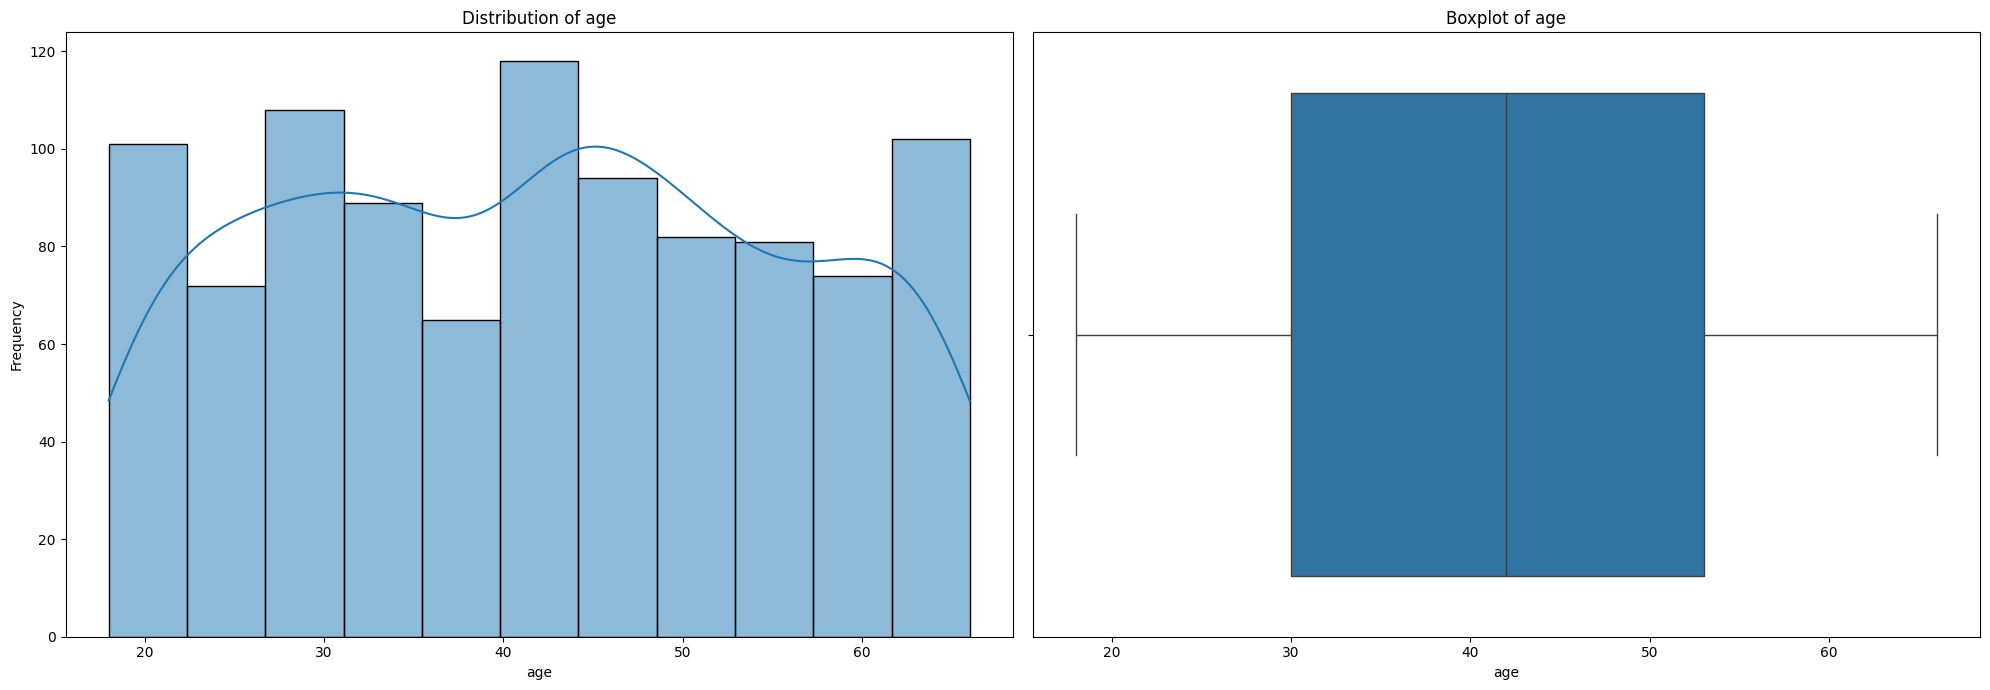

In [ ]:
# Age
hist_and_box_plot(df, 'age')

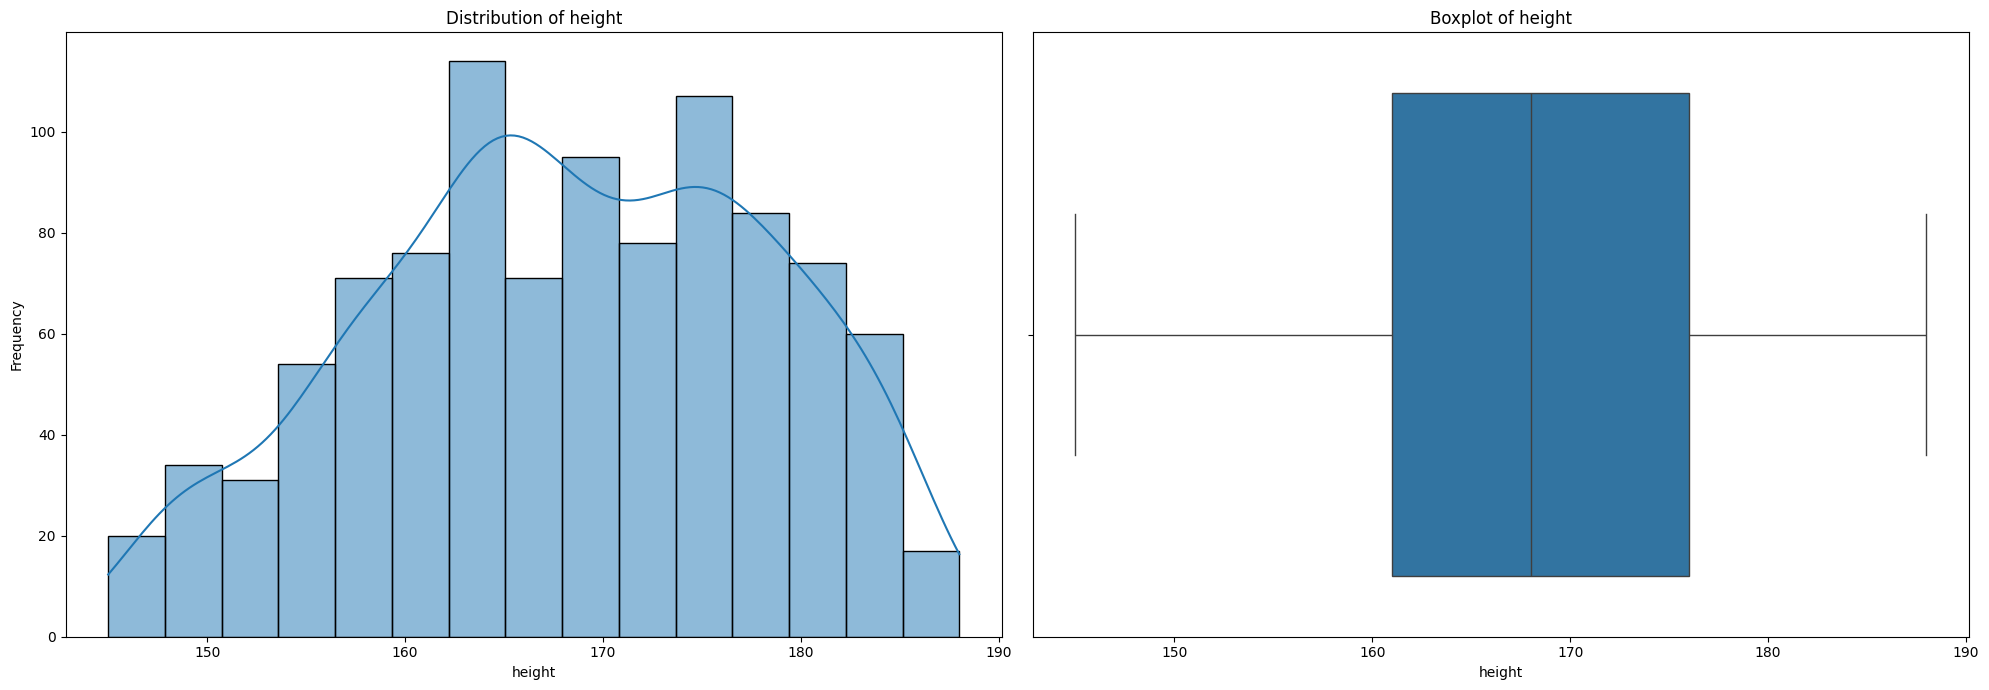

In [ ]:
# height
hist_and_box_plot(df, 'height')

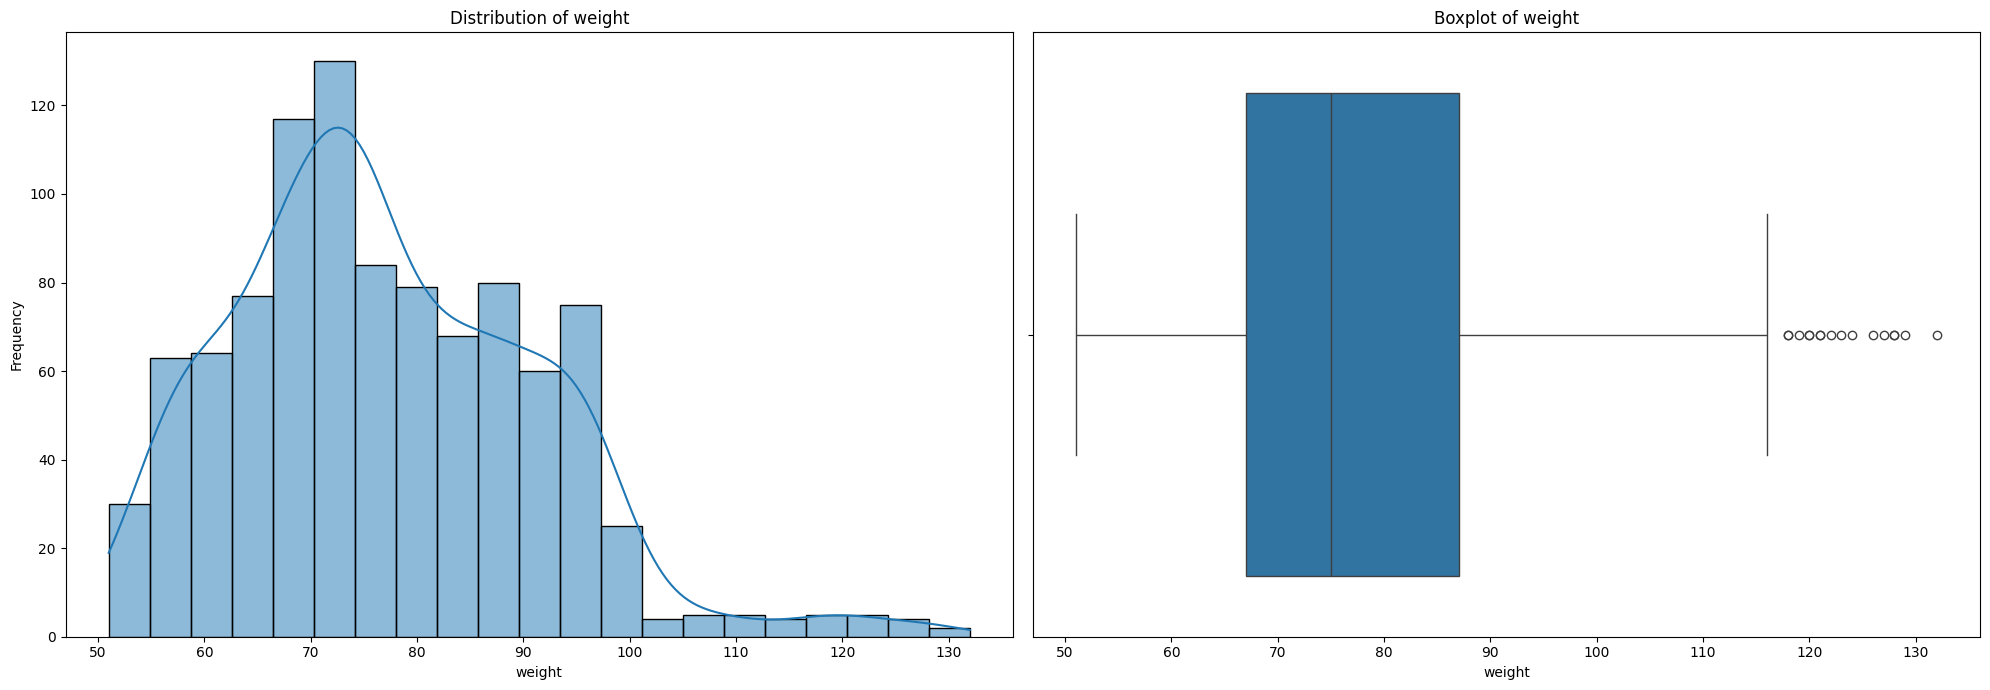

In [ ]:
# Weight
hist_and_box_plot(df, 'weight')

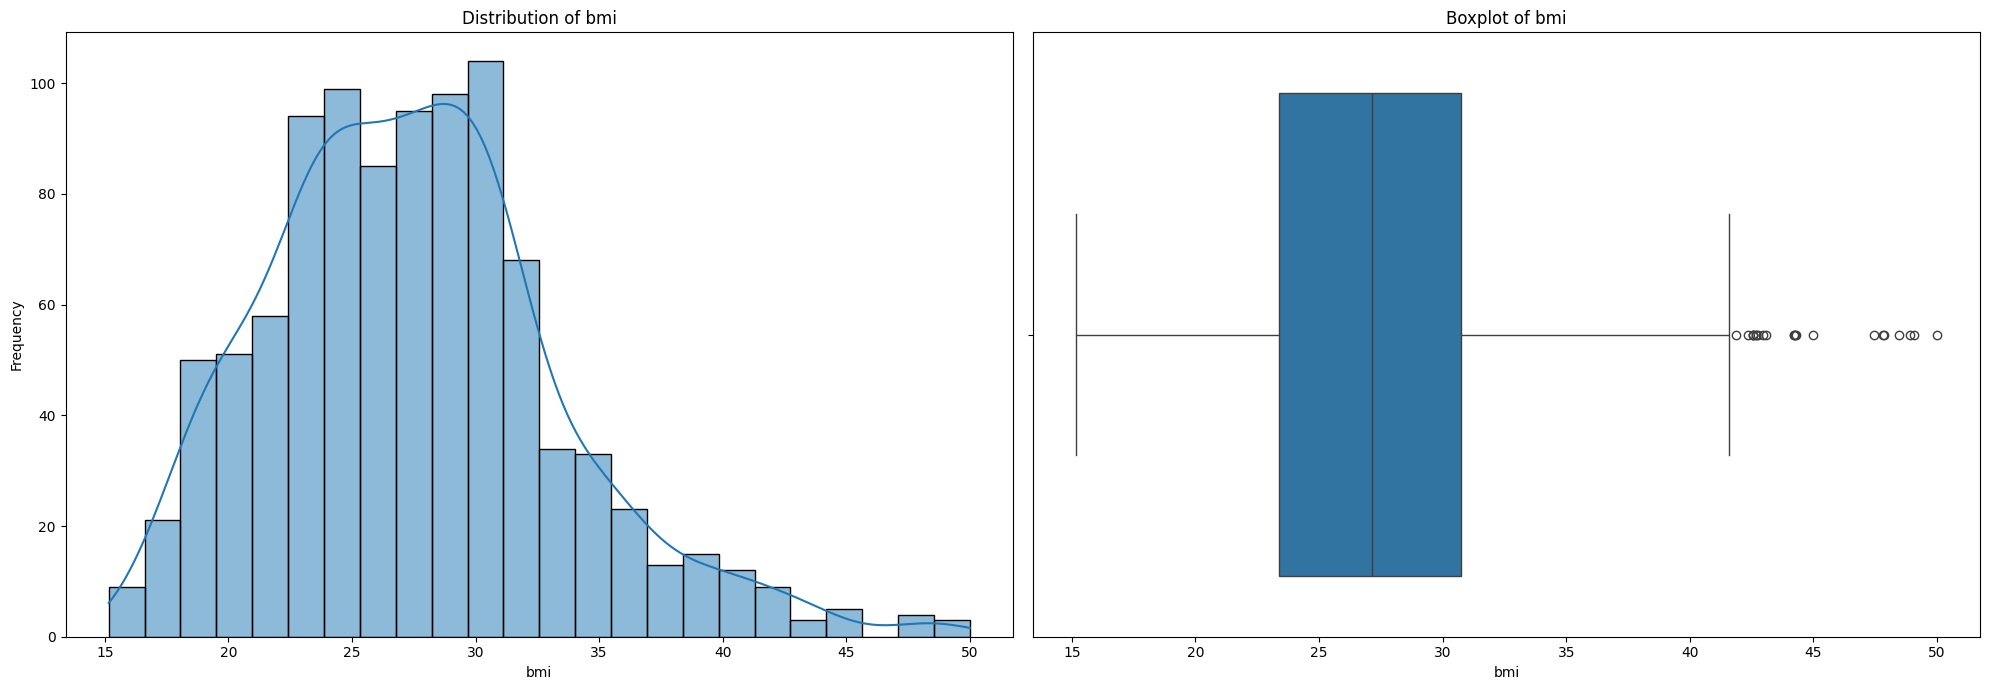

In [ ]:
# BMI
hist_and_box_plot(df, 'bmi')

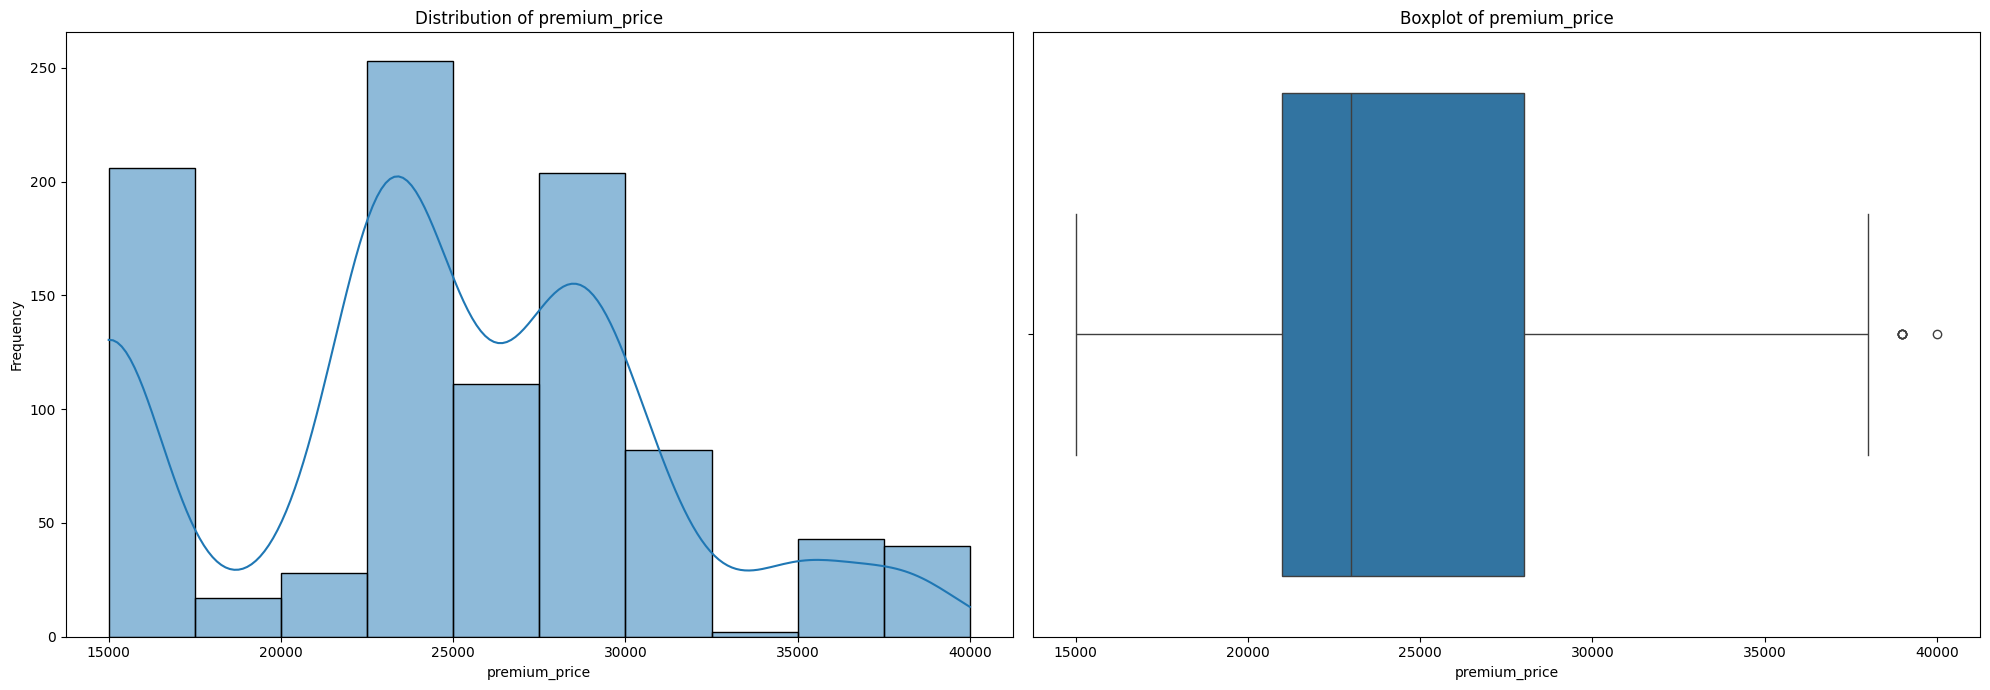

In [ ]:
# Premium Price
hist_and_box_plot(df, 'premium_price', binwidth=2500)

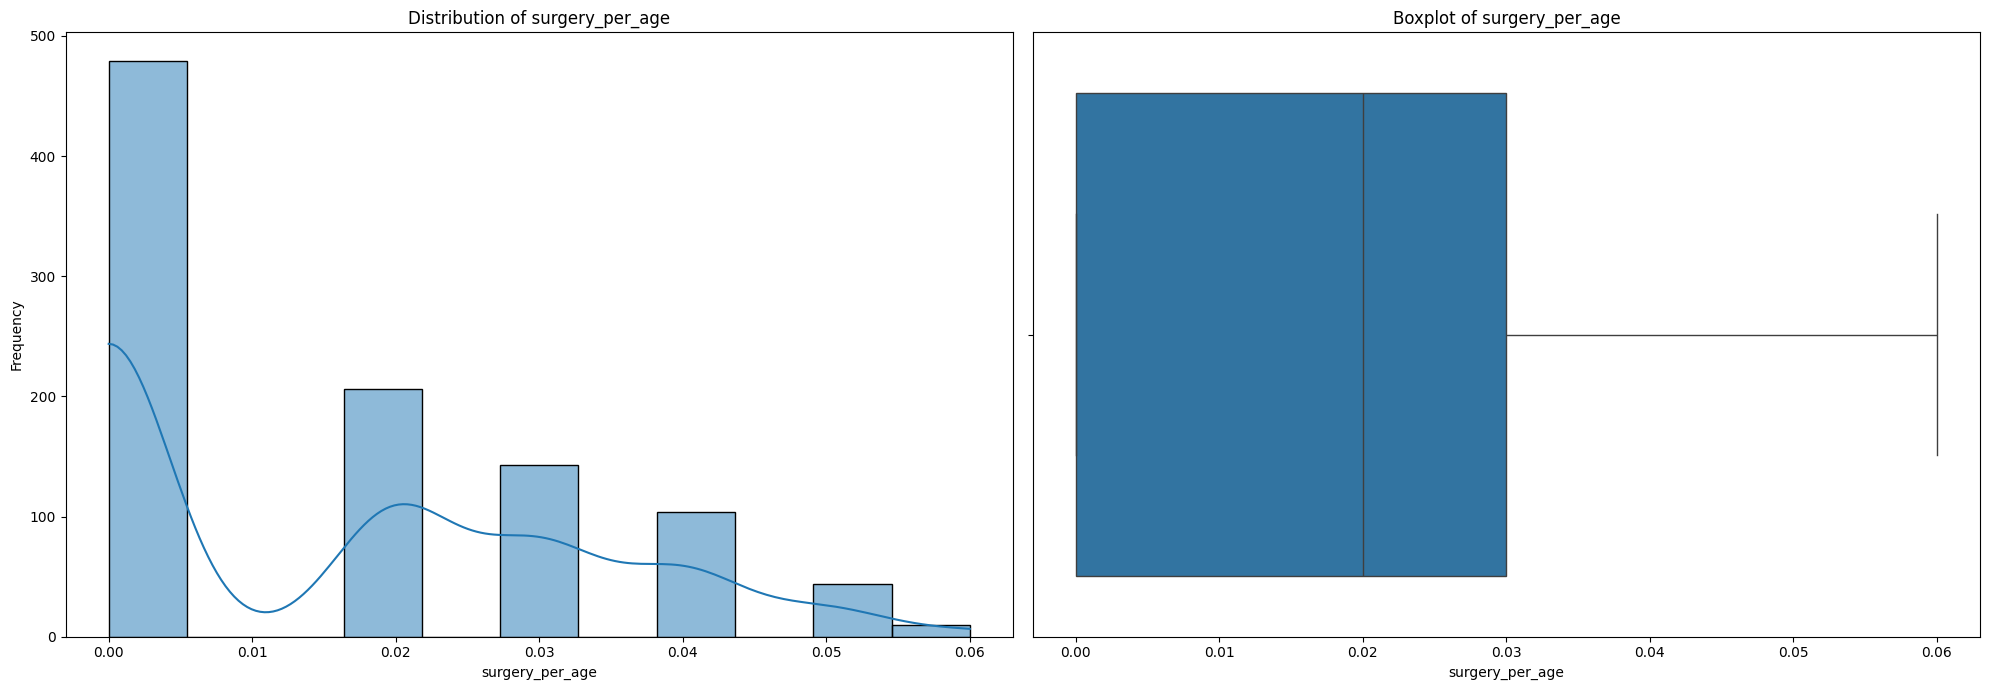

In [ ]:
# Surgeries Per Age
hist_and_box_plot(df, 'surgery_per_age')

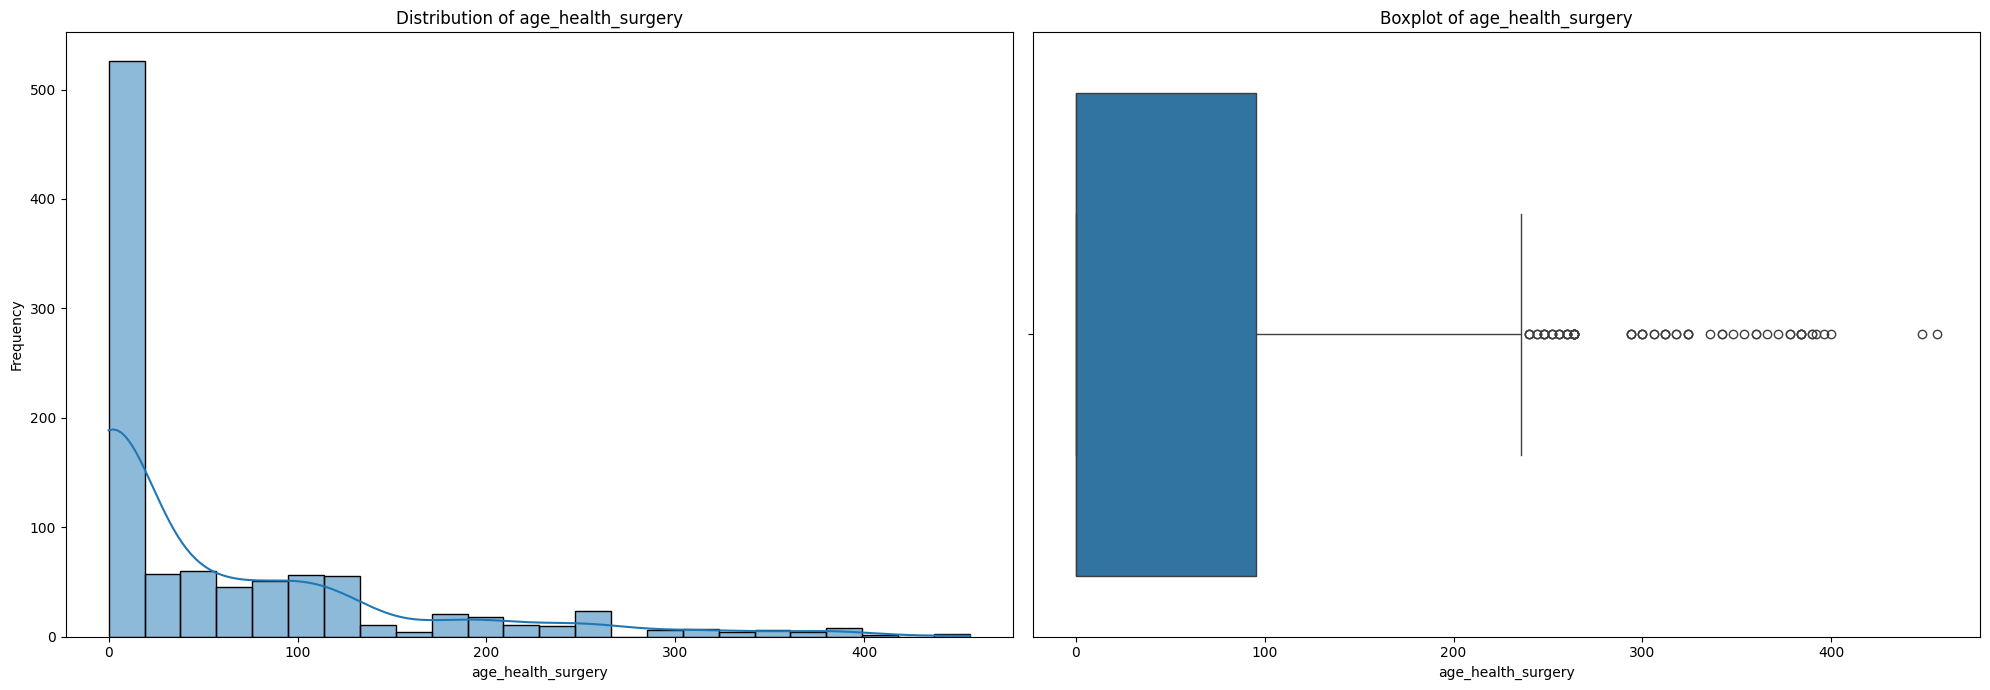

In [ ]:
# Age Health Surgery
hist_and_box_plot(df, 'age_health_surgery')

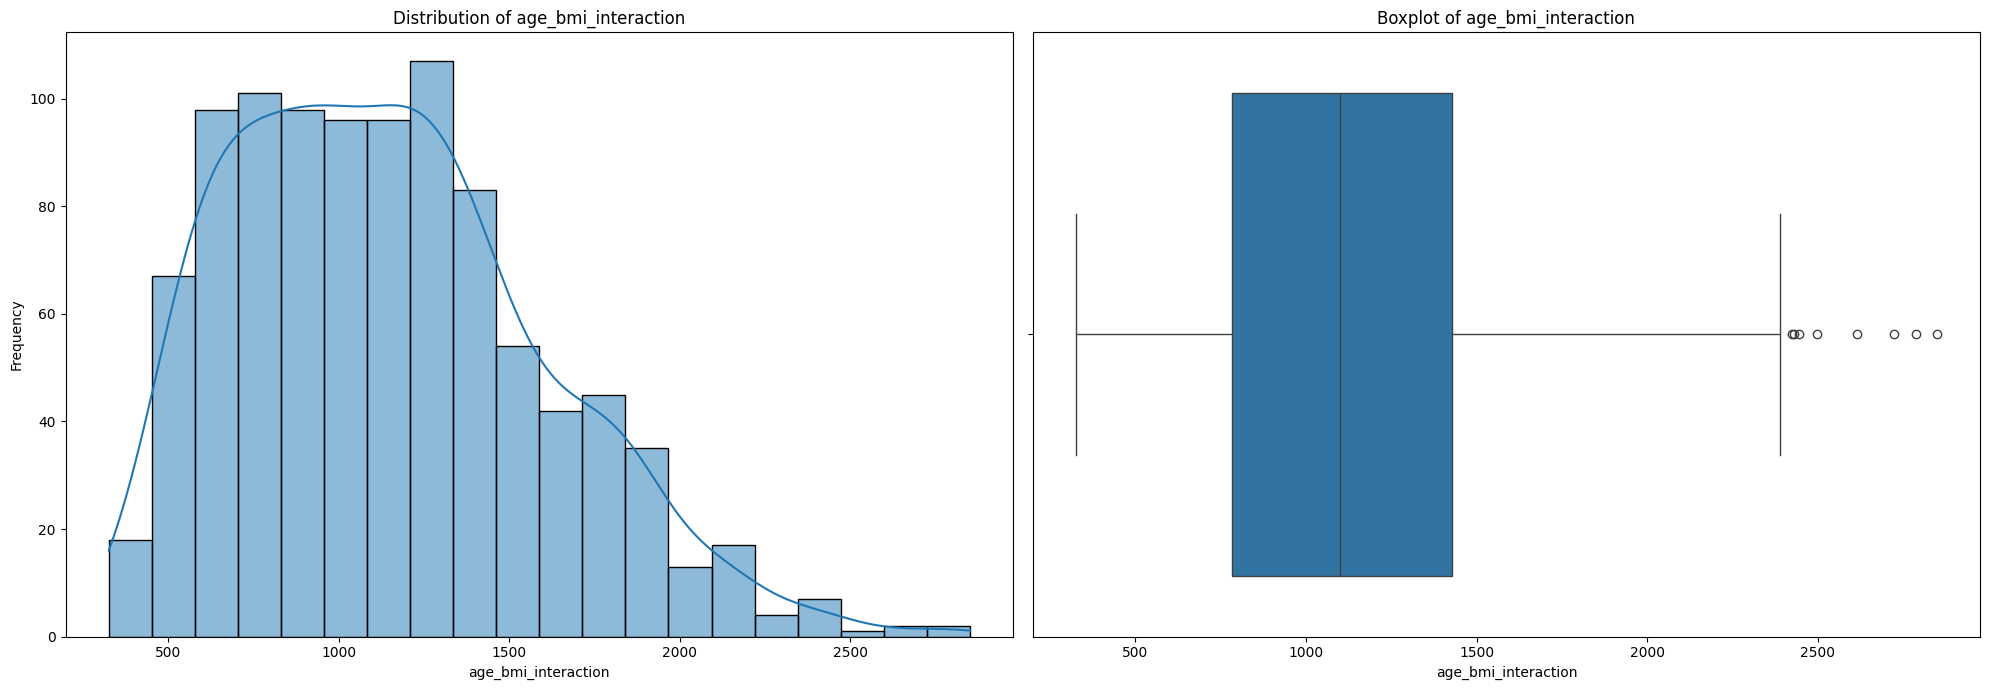

In [ ]:
hist_and_box_plot(df, 'age_bmi_interaction')

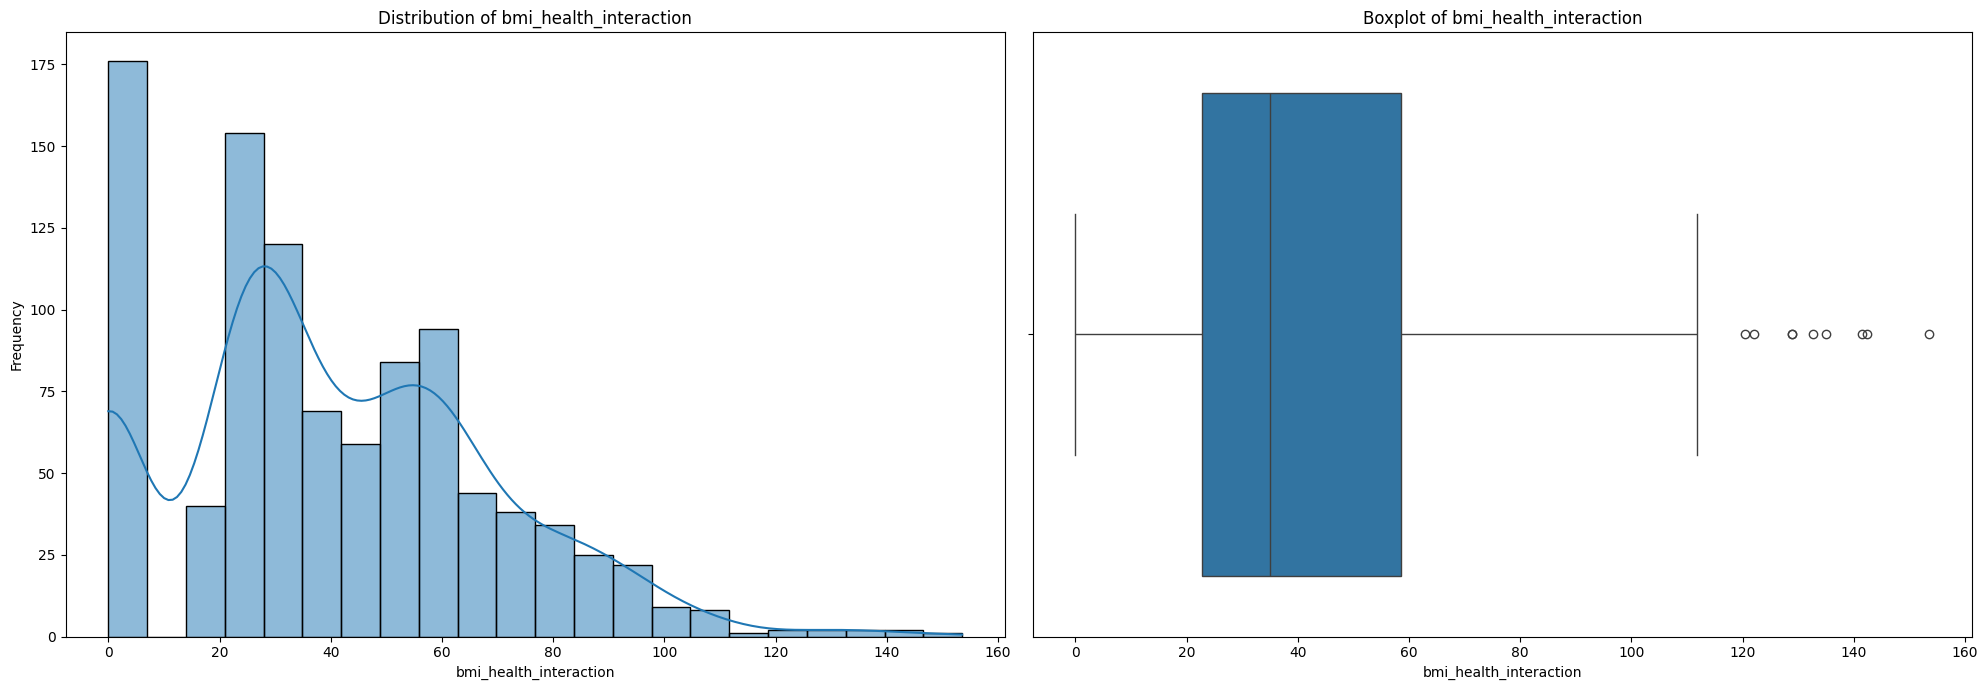

In [ ]:
hist_and_box_plot(df, 'bmi_health_interaction')

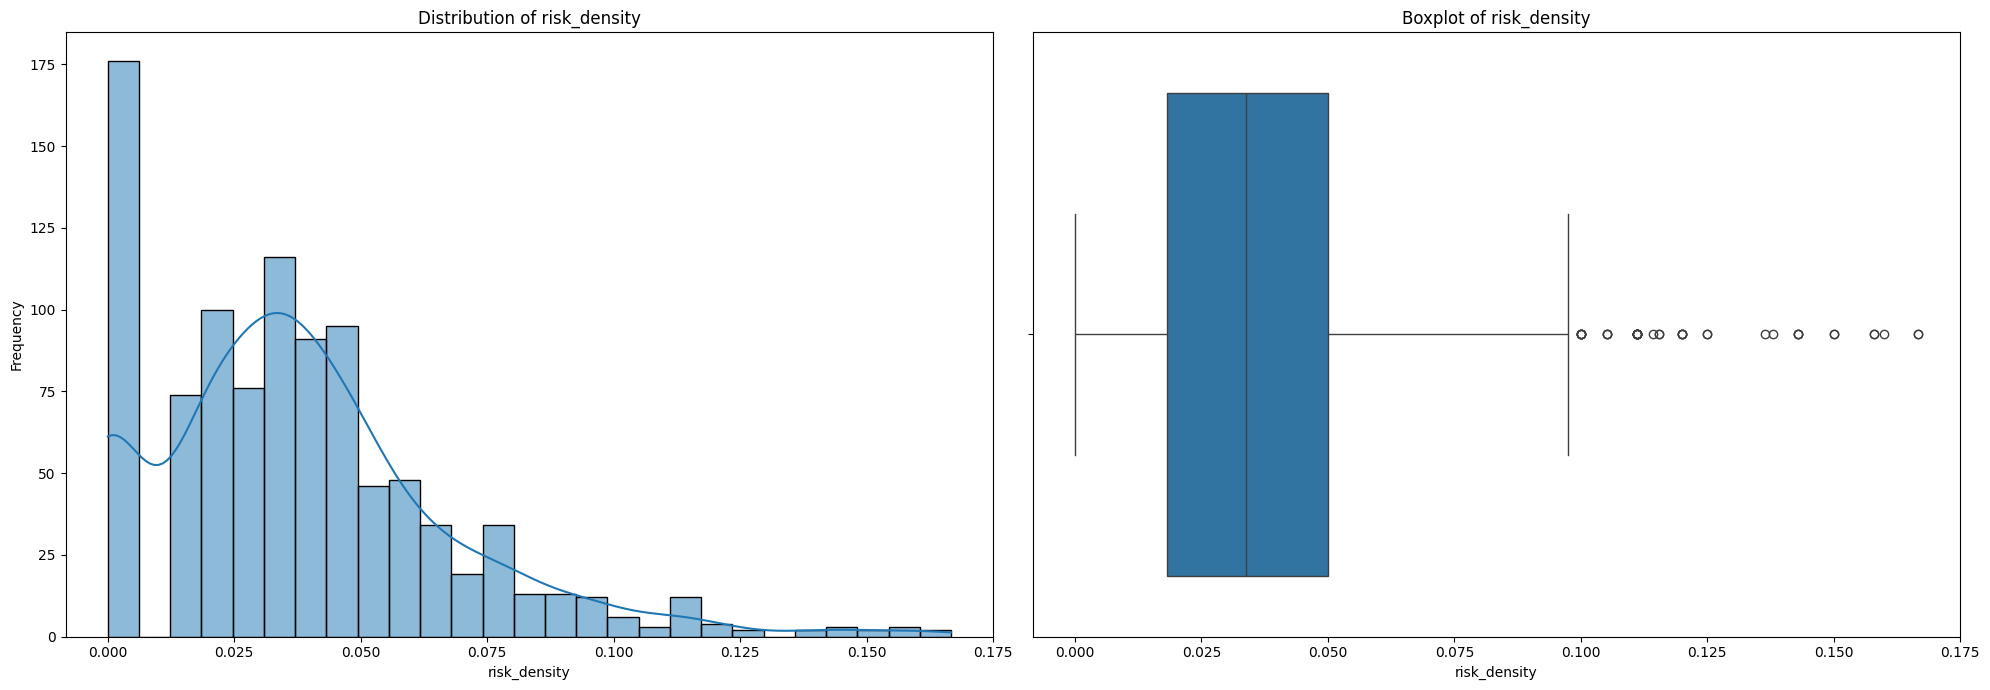

In [ ]:
hist_and_box_plot(df, 'risk_density')

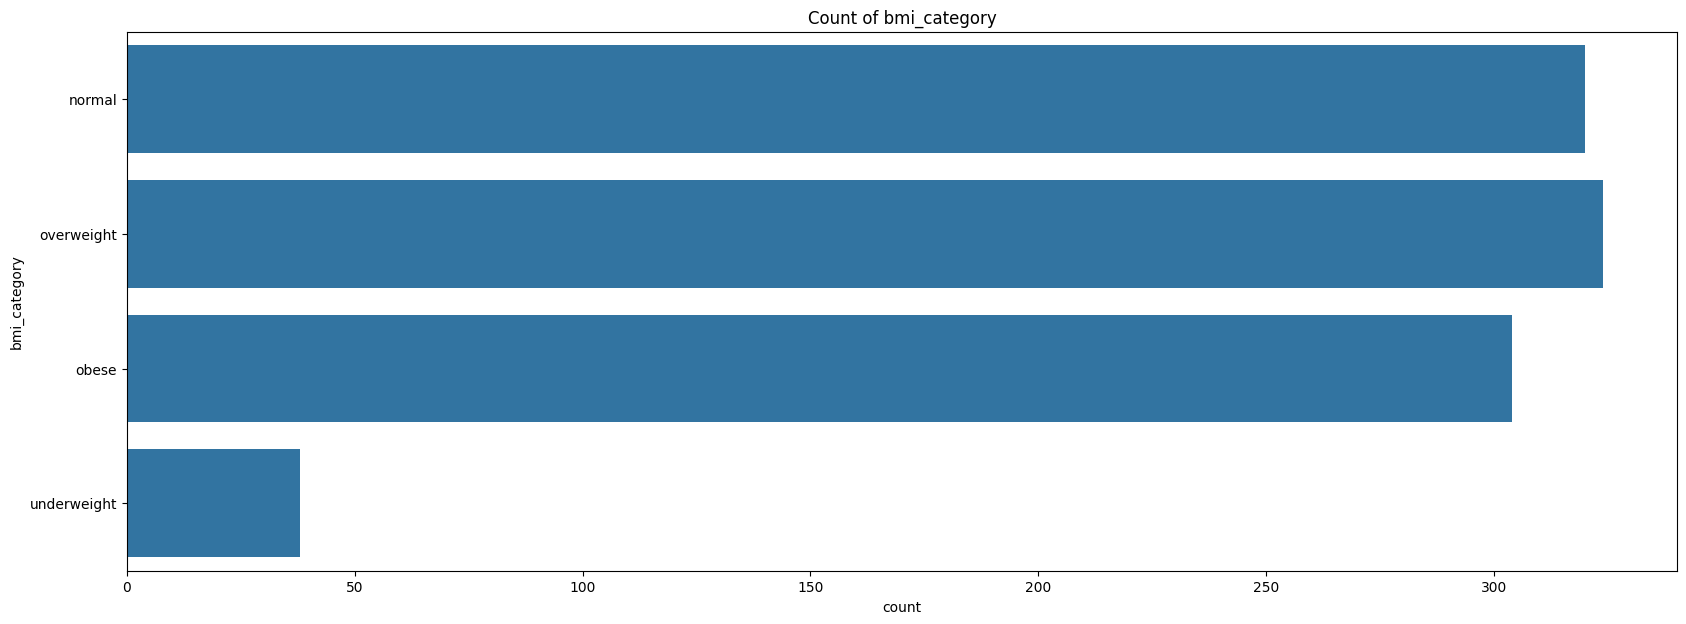

In [ ]:
# Count of bmi_category

plt.figure(figsize=(20, 7))
sns.countplot(df['bmi_category'])
plt.title('Count of bmi_category')
plt.show()

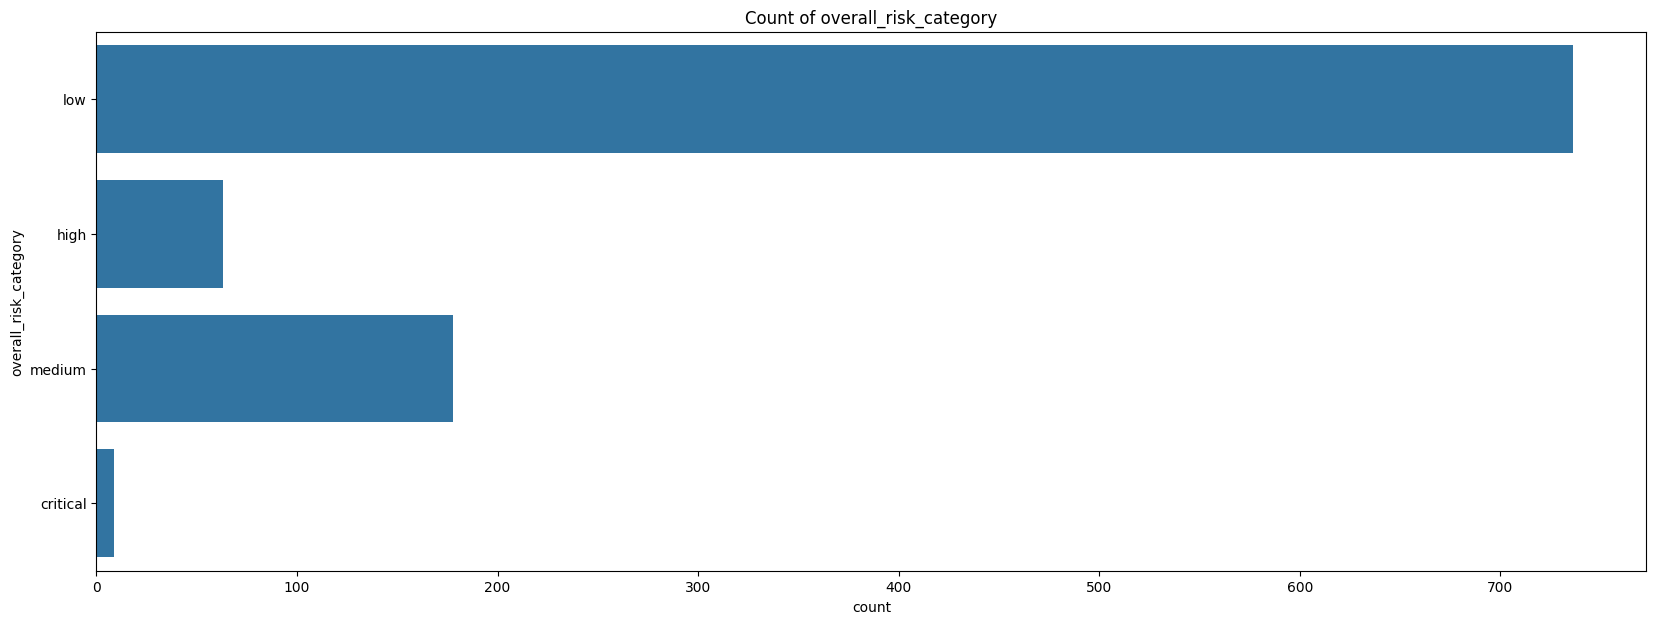

In [ ]:
# Count of overall_risk_category

plt.figure(figsize=(20, 7))
sns.countplot(df['overall_risk_category'])
plt.title('Count of overall_risk_category')
plt.show()

### Violin plots for categorical health condition combined with premium price, height, weight, bmi data

In [ ]:
def violin_plot(df, col, **kwargs):
  plt.figure(figsize=(20, 7))
  sns.violinplot(x=col, y='premium_price', data=df)#, ax=axes[0])
  plt.title(f'Distribution of {col} vs Premium')

  plt.tight_layout()
  plt.show()

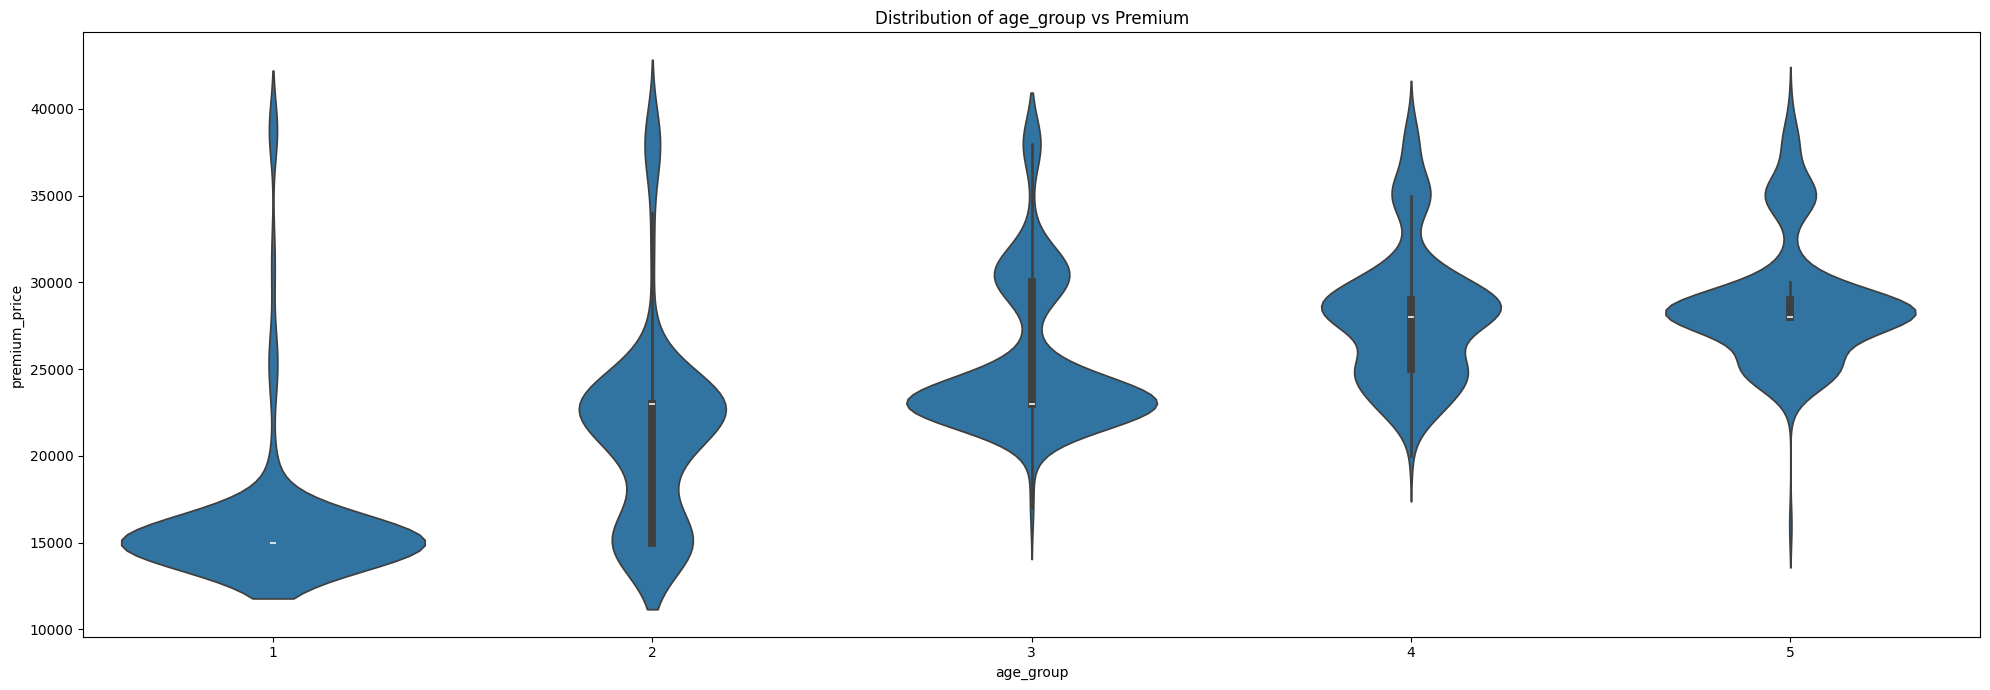

In [ ]:
violin_plot(df, 'age_group')

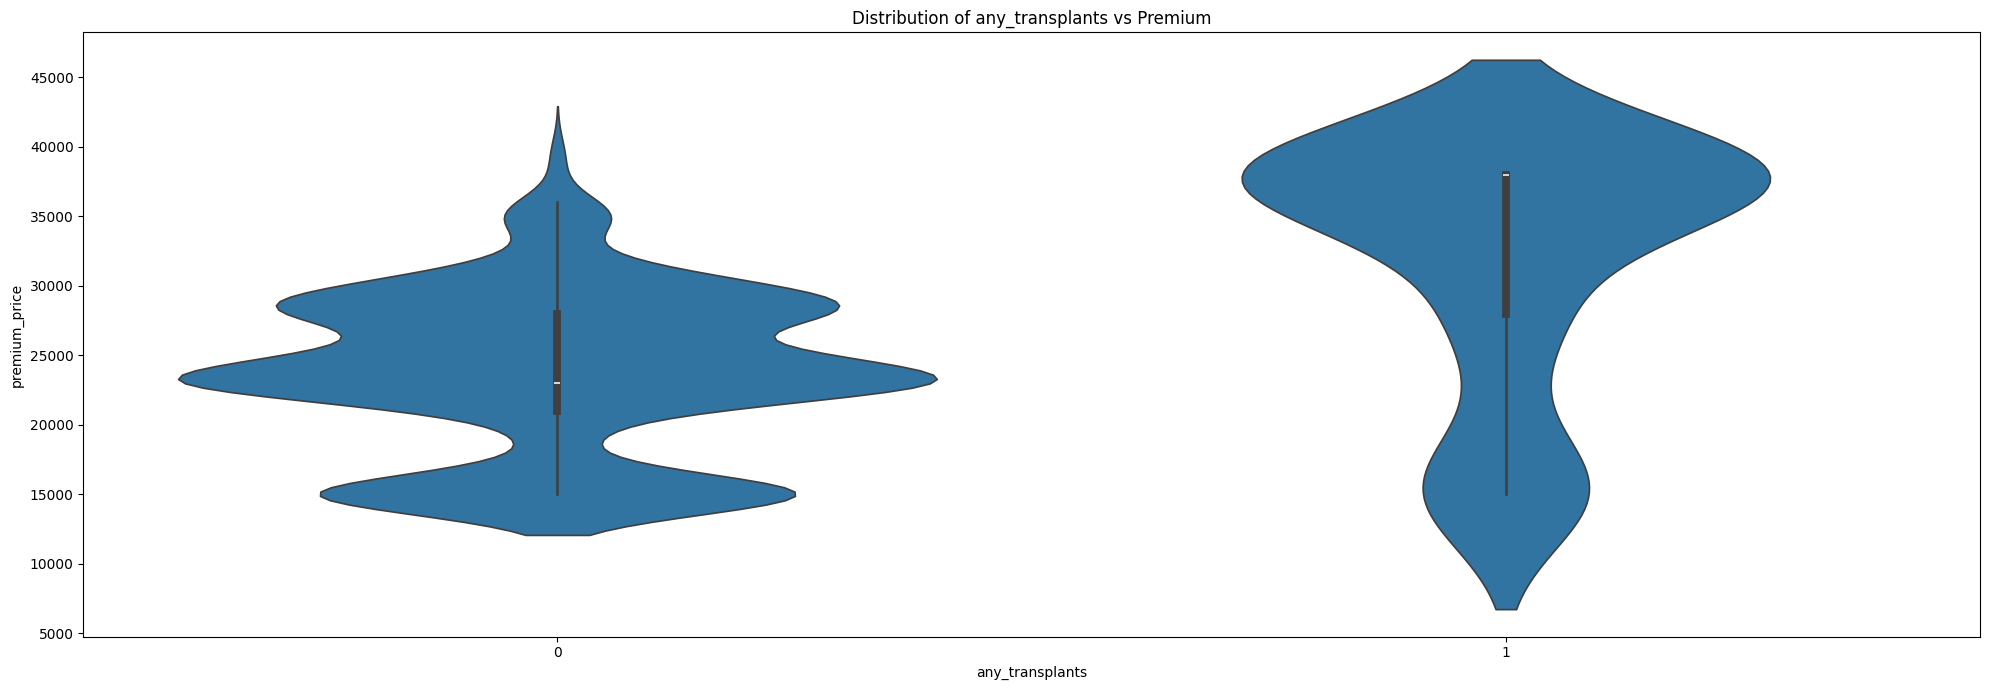

In [ ]:
violin_plot(df, 'any_transplants')

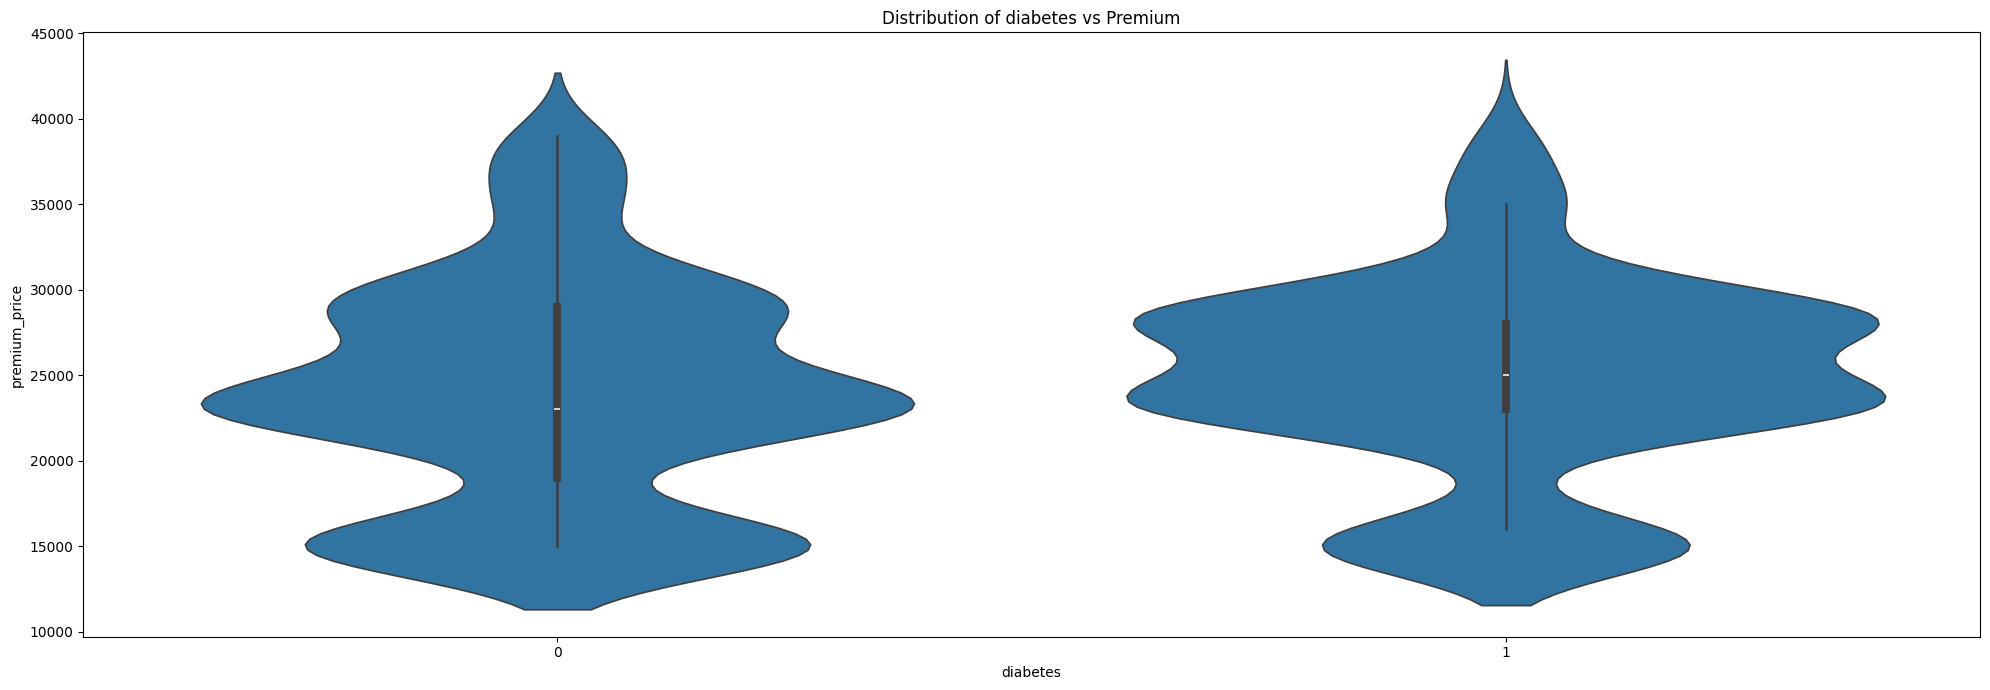

In [ ]:
violin_plot(df, 'diabetes')

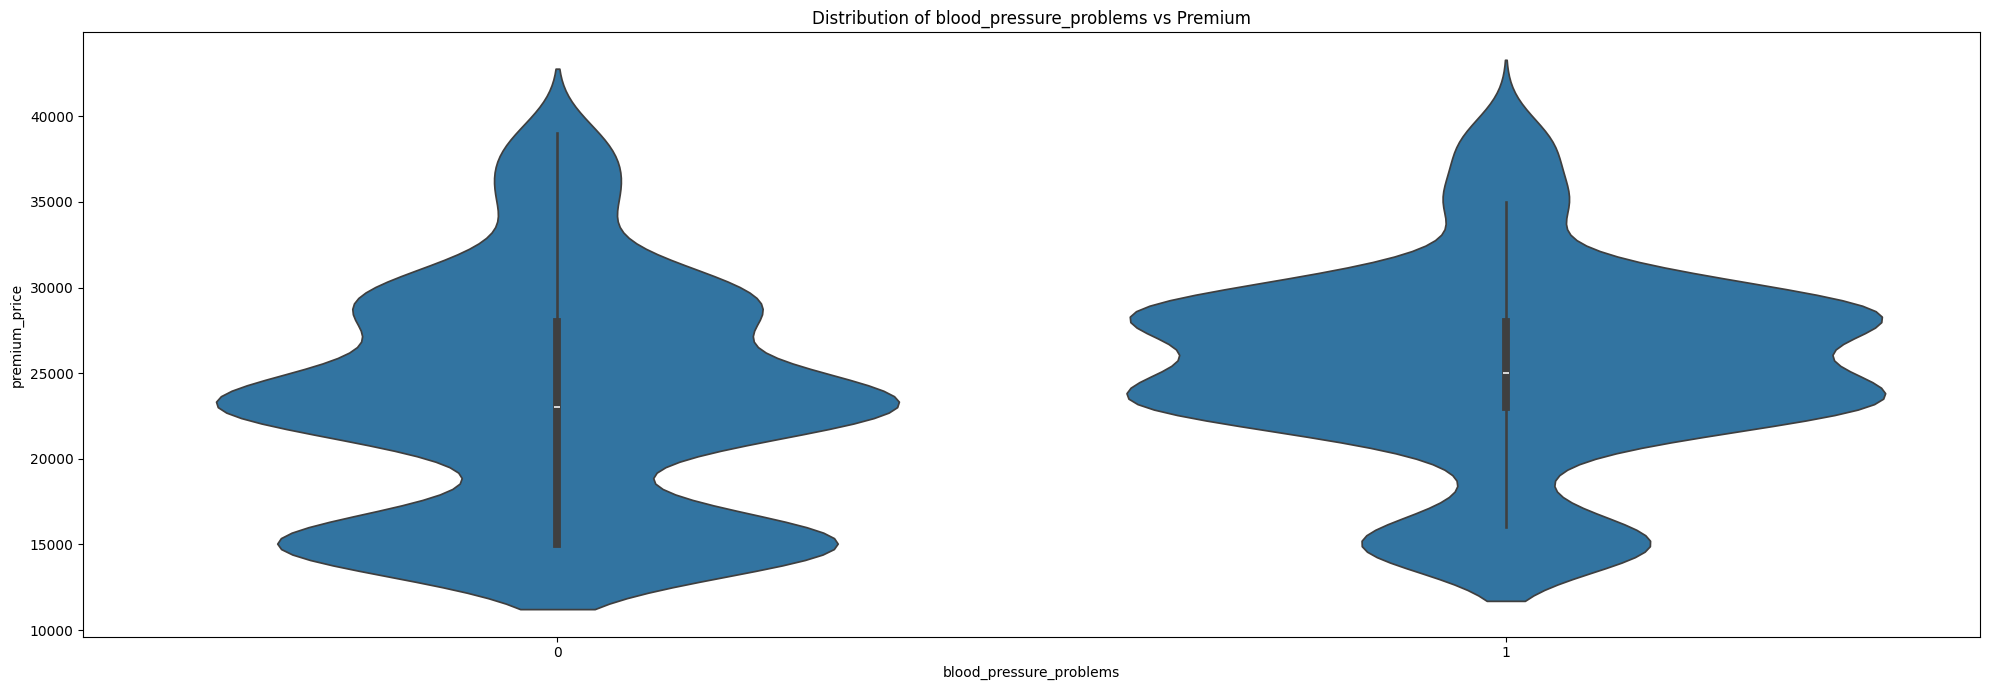

In [ ]:
violin_plot(df, 'blood_pressure_problems')

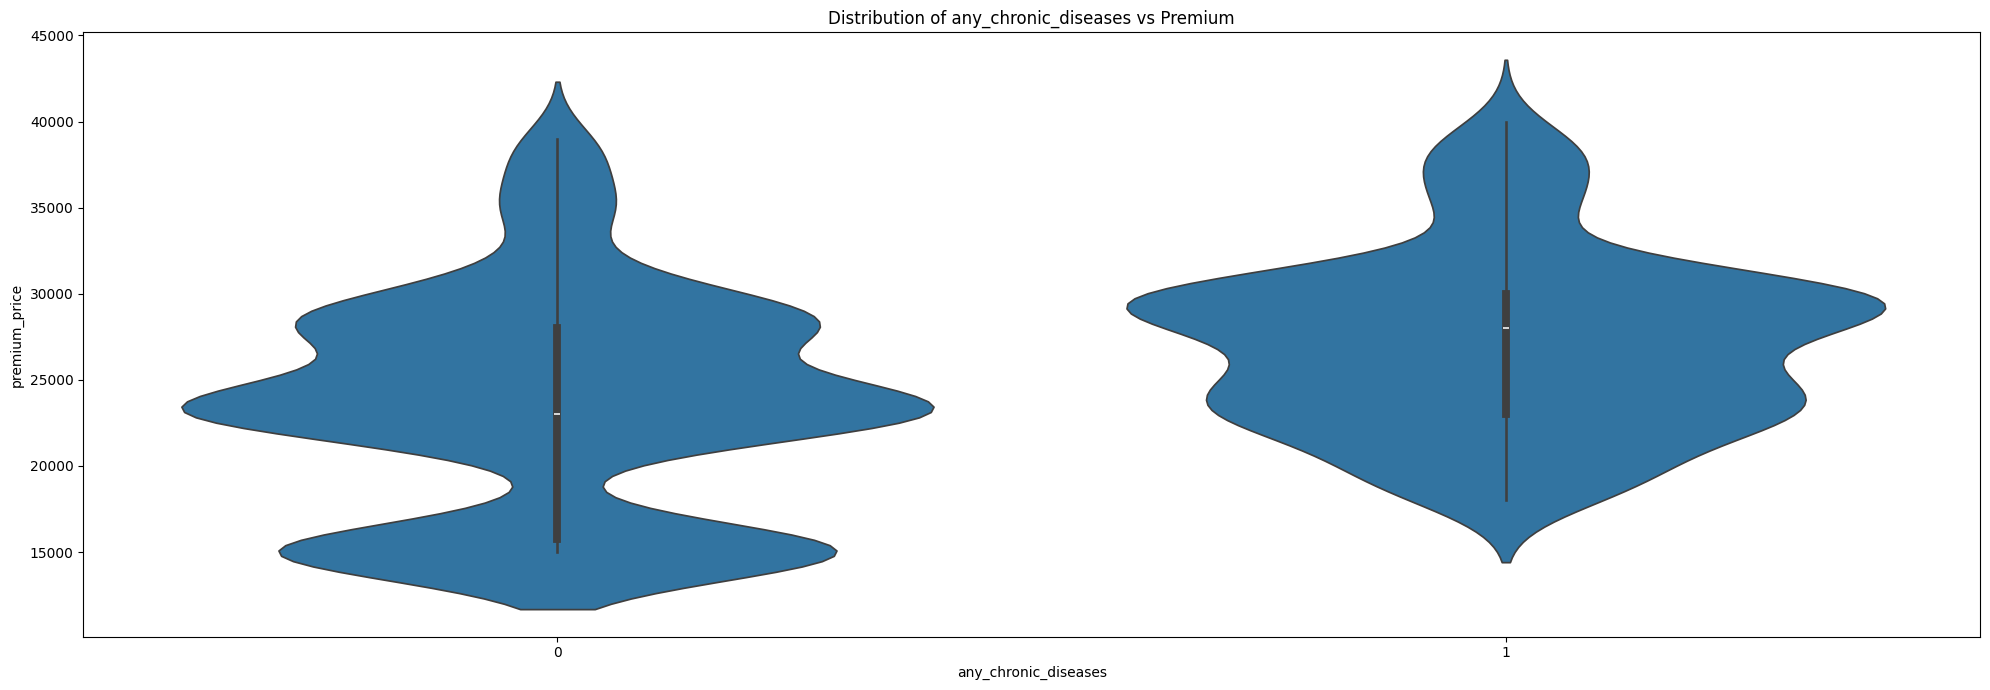

In [ ]:
violin_plot(df, 'any_chronic_diseases')

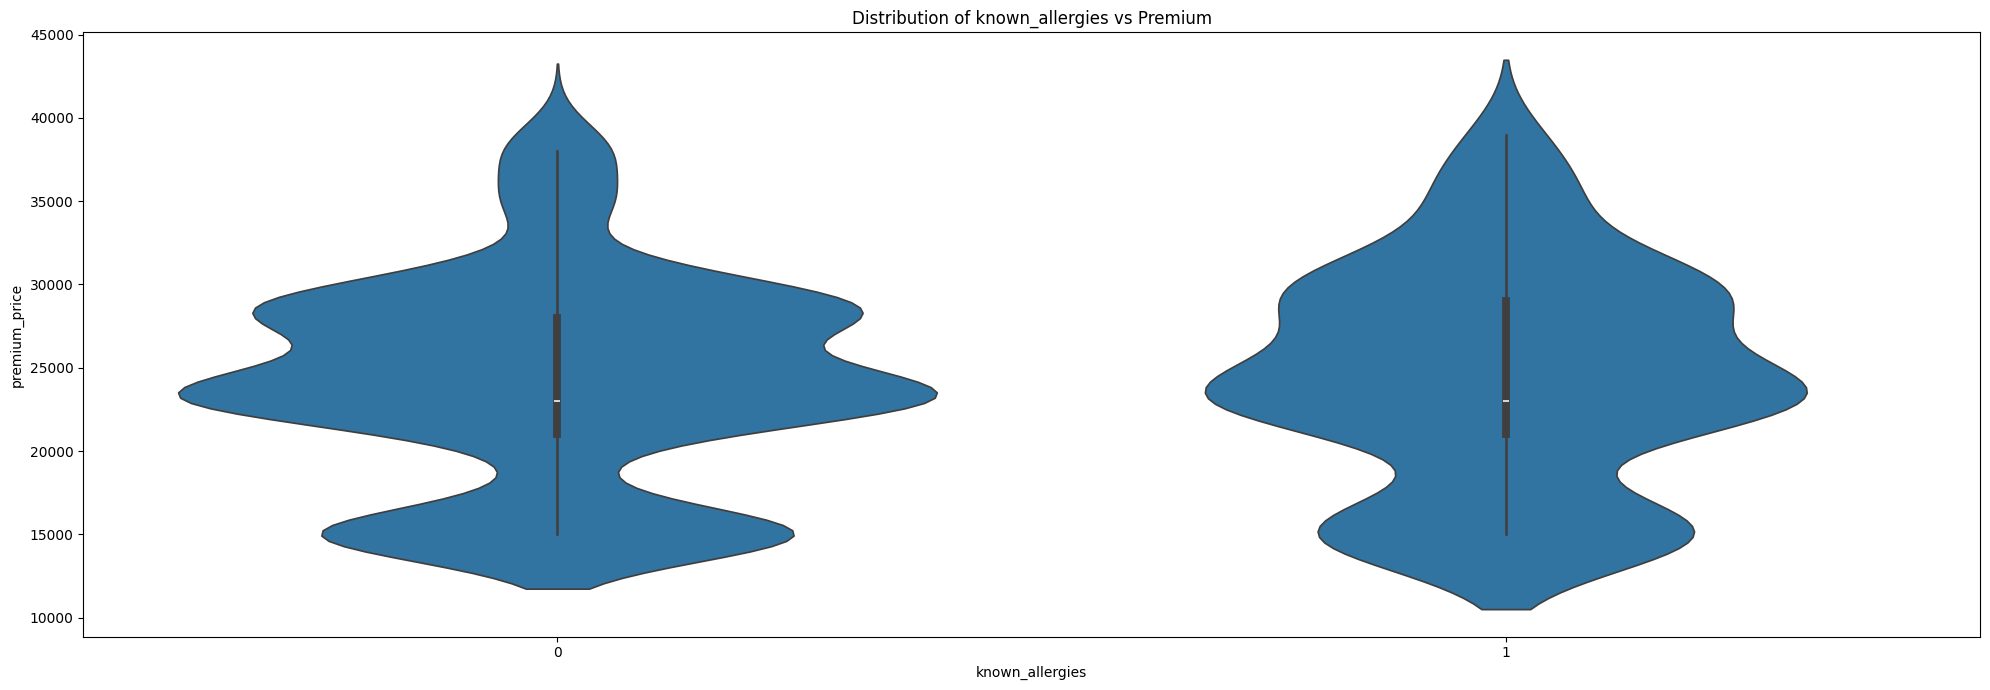

In [ ]:
violin_plot(df, 'known_allergies')

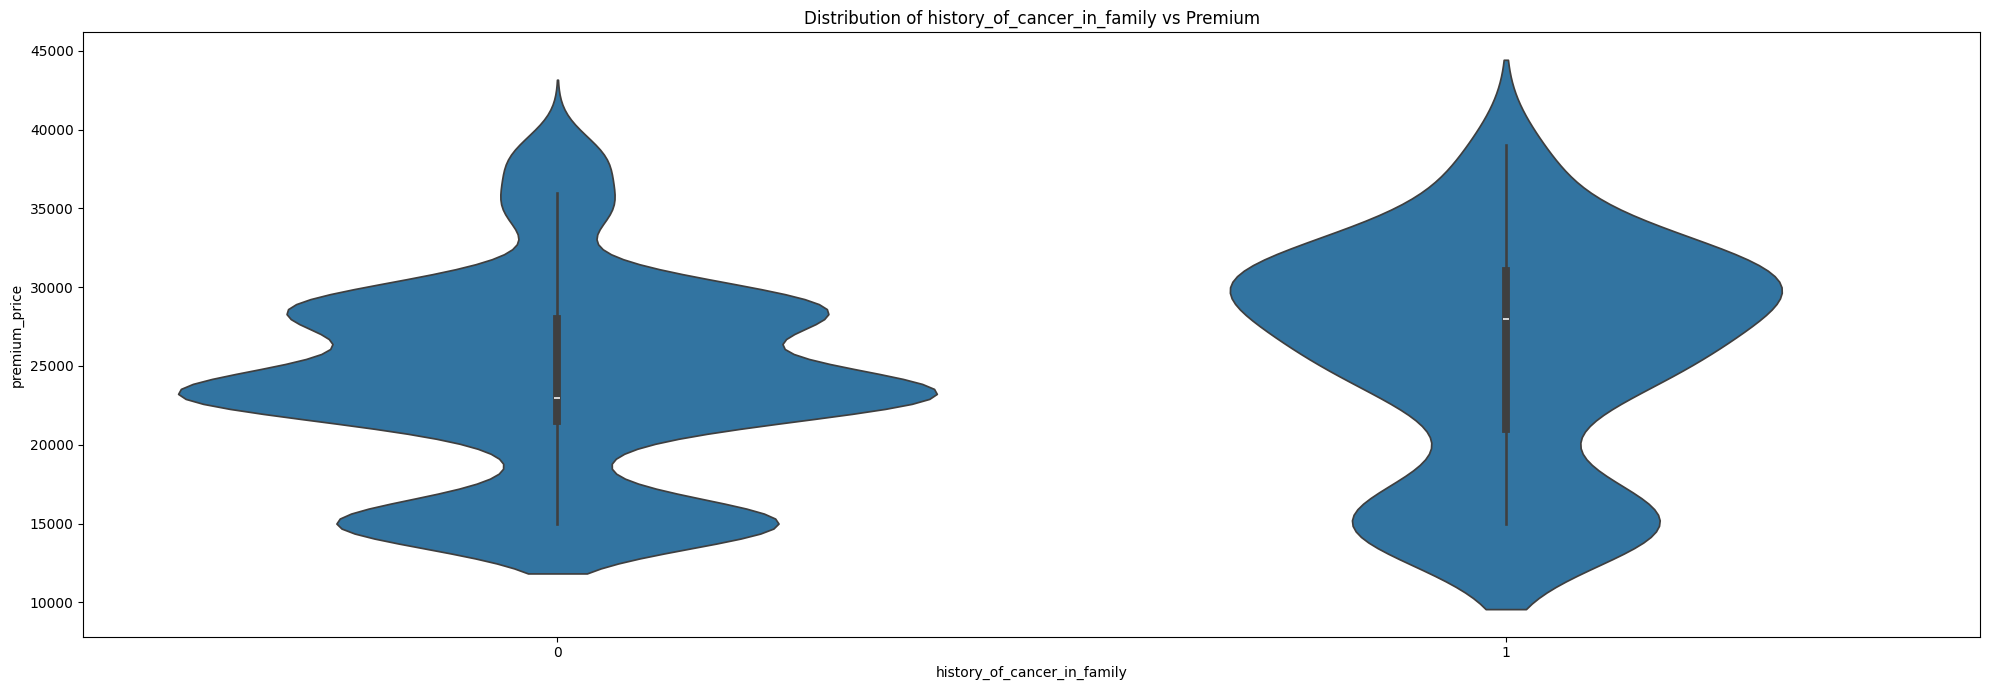

In [ ]:
violin_plot(df, 'history_of_cancer_in_family')

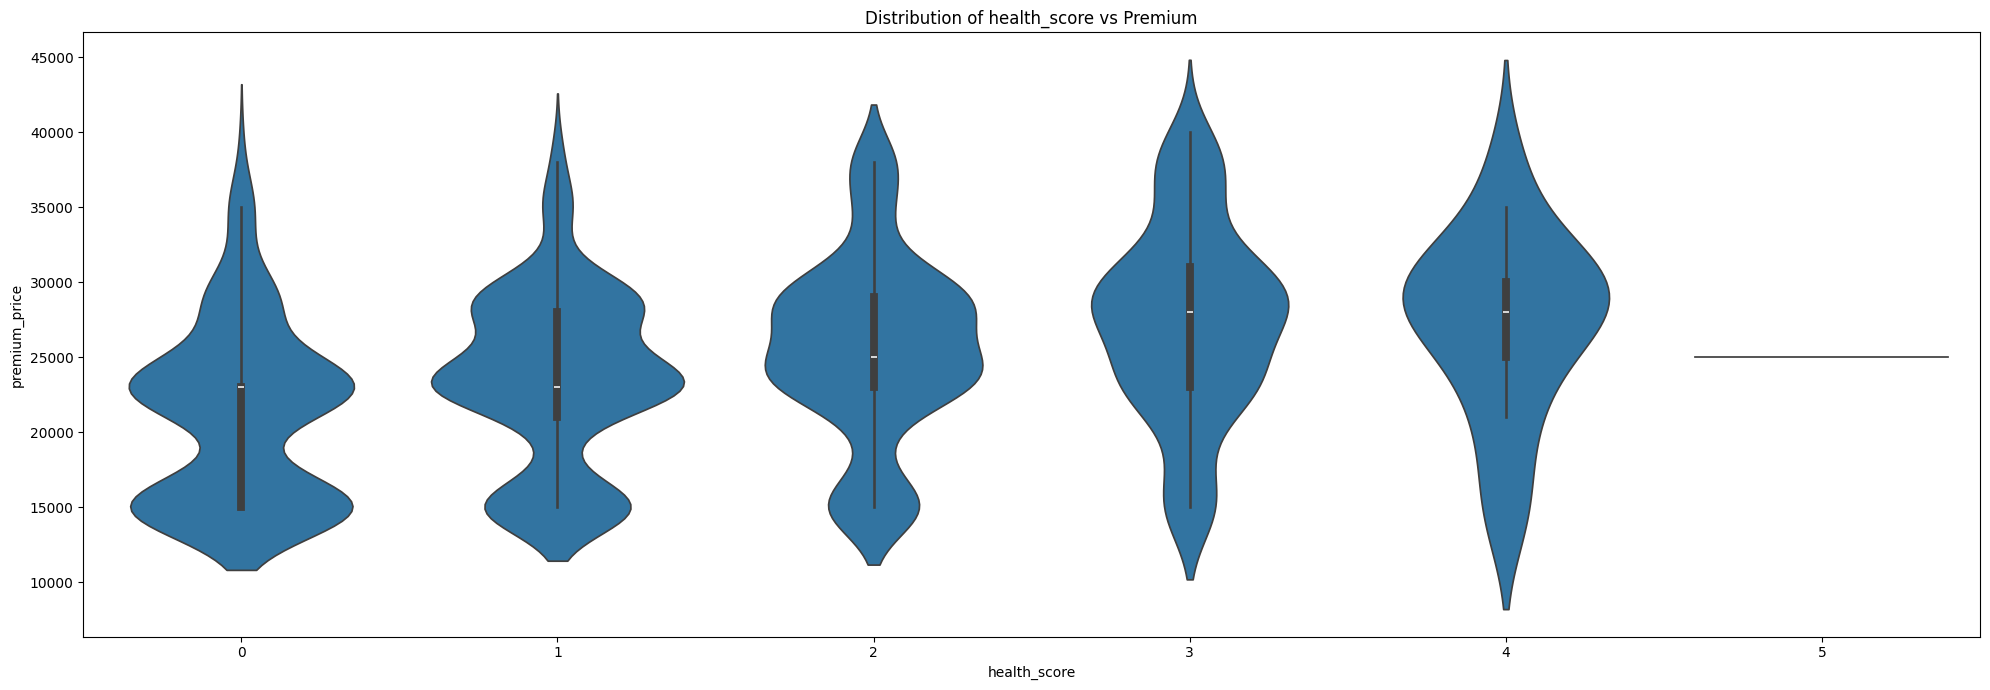

In [ ]:
violin_plot(df, 'health_score')

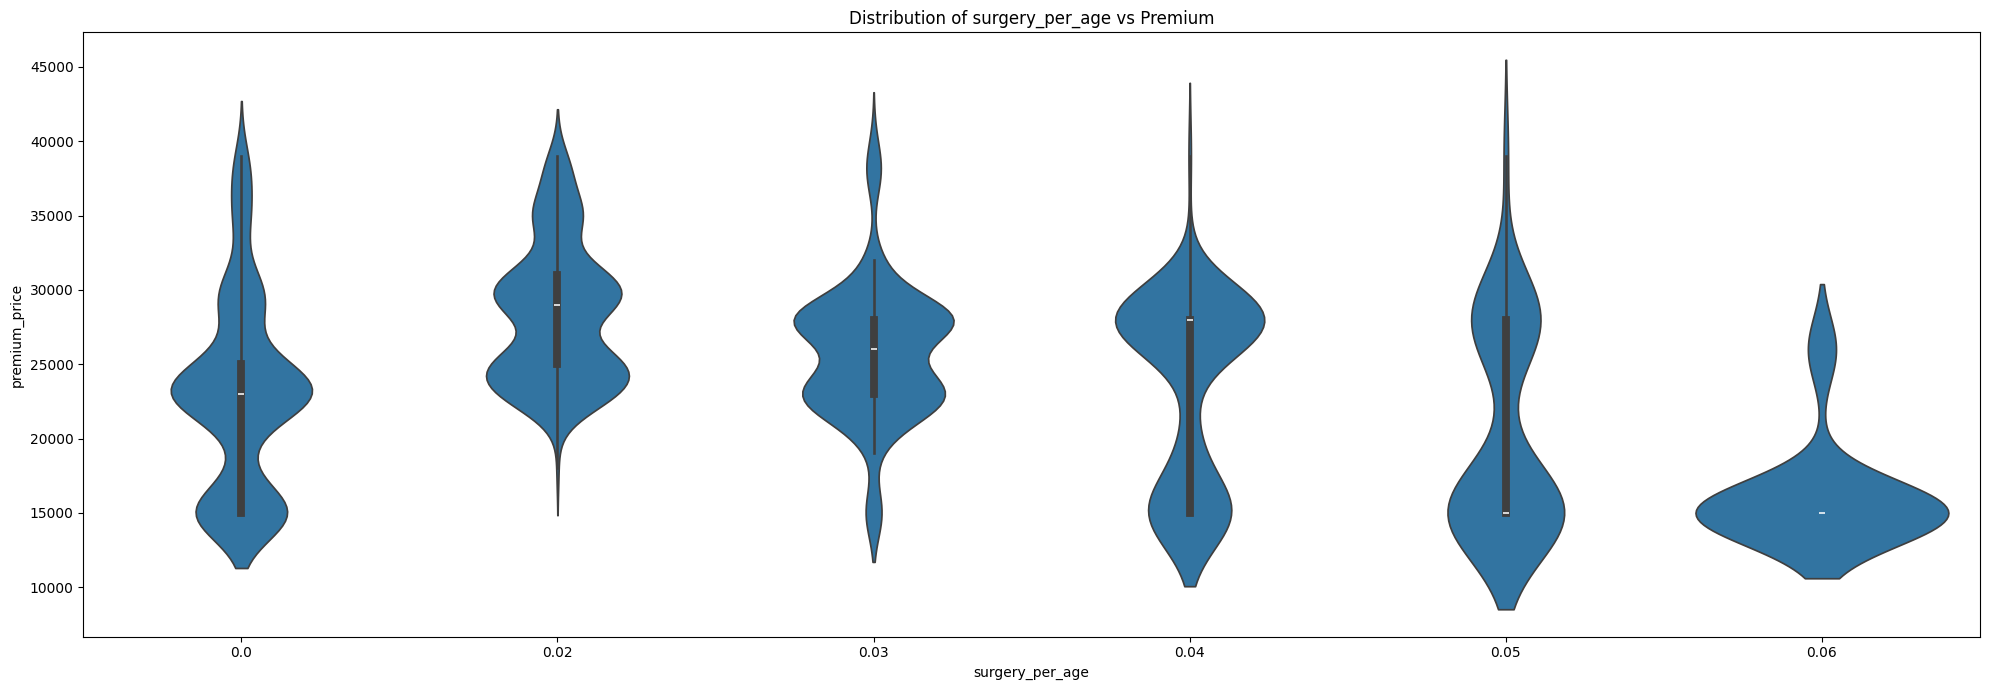

In [ ]:
violin_plot(df, 'surgery_per_age')

## Correlation Analysis

In [ ]:
correlation_cols = ['age', 'height', 'weight', 'bmi', 'health_score',
                    'surgery_per_age', 'age_health_surgery', 'premium_price',
                    'age_bmi_interaction', 'bmi_health_interaction', 'age_squared',
                    'risk_density']

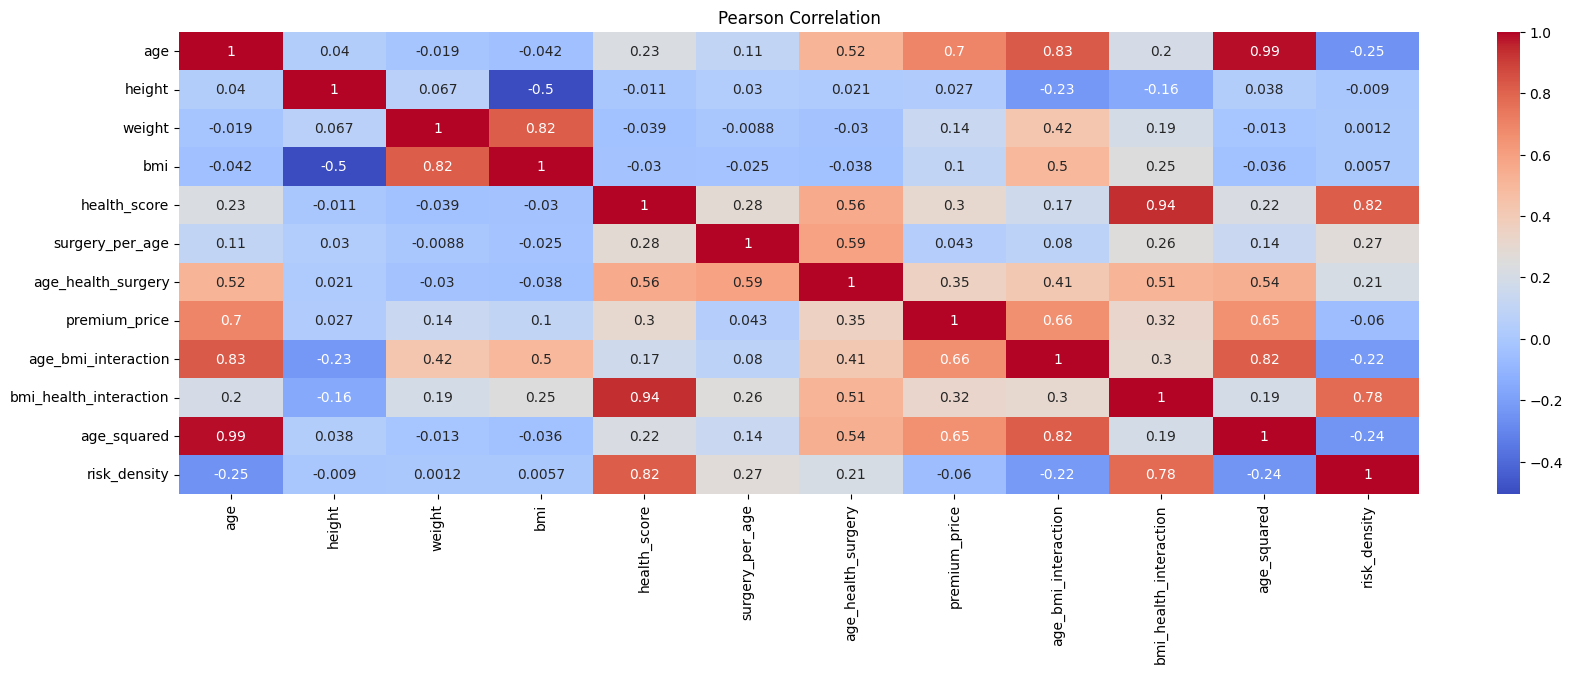

In [ ]:
plt.figure(figsize=(20, 6))
sns.heatmap(df[correlation_cols].corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title("Pearson Correlation")
plt.show()

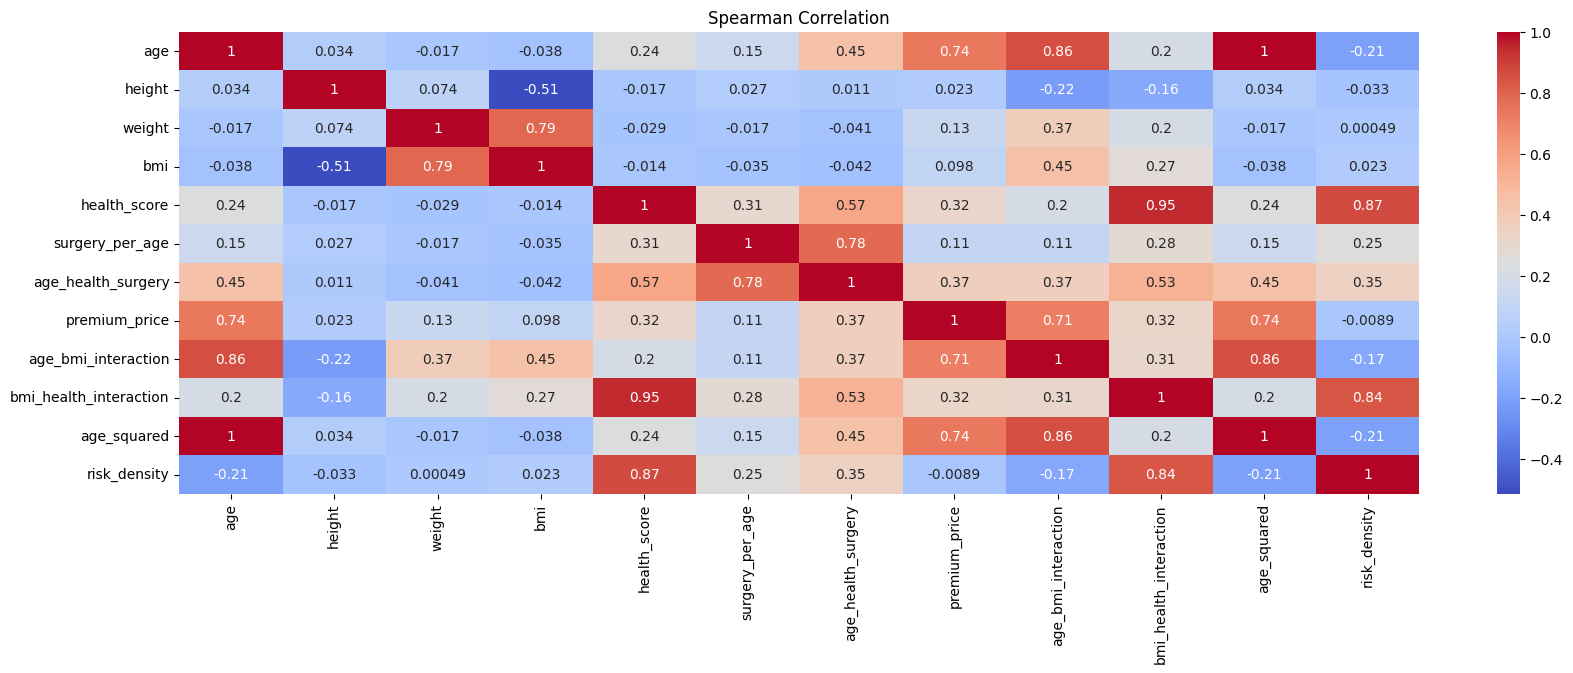

In [ ]:
plt.figure(figsize=(20, 6))
sns.heatmap(df[correlation_cols].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title("Spearman Correlation")
plt.show()

## Outlier Detection

In [ ]:
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    return outliers.shape[0]

numerical_columns = ['age', 'height', 'weight', 'bmi',
                    'surgery_per_age', 'age_health_surgery',
                     'premium_price', 'age_bmi_interaction',
                     'bmi_health_interaction', 'age_squared',
                     'risk_density']

In [ ]:
outliers = {
    'Column': [],
    '# of outlier rows' : []
}
for cols in numerical_columns:
  num_outliers = detect_outliers_iqr(df, cols)
  outliers['Column'].append(cols)
  outliers['# of outlier rows'].append(num_outliers)

pd.DataFrame(outliers)

,Column,# of outlier rows
0,age,0
1,height,0
2,weight,16
3,bmi,22
4,surgery_per_age,0
5,age_health_surgery,66
6,premium_price,6
7,age_bmi_interaction,8
8,bmi_health_interaction,9
9,age_squared,0


# Hypothesis Testing

## T-Test : Mean values across different binary variables


In [ ]:
def conduct_ttest_ind(check_col):
  """
  Parameters:

  check_col : The column where the test is conducted to compare the rest
              of the variables
  """

  true_cond = df[df[check_col] == 1][cols]
  false_cond = df[df[check_col] == 0][cols]

  tstat, pval = ttest_ind(true_cond, false_cond)

  res = pd.DataFrame({'t-statistics': tstat, 'p-value': pval}, index=cols)
  res['is_significant'] = np.where(res['p-value'] < alpha, 'Yes', 'No')

  return res

cols = ['age', 'premium_price', 'bmi', 'weight',
        'height', 'number_of_major_surgeries']

alpha = 0.05

### Diabetes

In [ ]:
res = conduct_ttest_ind('diabetes')
res

,t-statistics,p-value,is_significant
age,6.768168,2.237336e-11,Yes
premium_price,2.397563,1.669009e-02,Yes
bmi,-0.718595,4.725609e-01,No
weight,-0.770747,4.410419e-01,No
height,-0.118654,9.055738e-01,No
number_of_major_surgeries,3.878975,1.118713e-04,Yes


In [ ]:
"""
Interpretation:

Age : People with diabetes are significantly older
Premium Price : Premiums are higher for diabetic individuals
Number of major surgeries : Diabetic people had more surgeries

BMI, Height, Weight : No significant difference here
"""

'\nInterpretation:\n\nAge : People with diabetes are significantly older\nPremium Price : Premiums are higher for diabetic individuals\nNumber of major surgeries : Diabetic people had more surgeries\n\nBMI, Height, Weight : No significant difference here\n'

### blood_pressure_problems

In [ ]:
res = conduct_ttest_ind('blood_pressure_problems')
res

,t-statistics,p-value,is_significant
age,7.923099,6.242463e-15,Yes
premium_price,5.316366,1.310050e-07,Yes
bmi,-1.193698,2.328840e-01,No
weight,-1.917571,5.545469e-02,No
height,-1.190546,2.341190e-01,No
number_of_major_surgeries,8.153591,1.068976e-15,Yes


In [ ]:
"""
Interpretation:

Age : People with diabetes are significantly older
Premium Price : Premiums are higher for diabetic individuals
Number of major surgeries : Diabetic people had more surgeries

BMI, Height, Weight : No significant difference here
"""

'\nInterpretation:\n\nAge : People with diabetes are significantly older\nPremium Price : Premiums are higher for diabetic individuals\nNumber of major surgeries : Diabetic people had more surgeries\n\nBMI, Height, Weight : No significant difference here\n'

### any_transplants

In [ ]:
res = conduct_ttest_ind('any_transplants')
res

,t-statistics,p-value,is_significant
age,-0.268185,7.886130e-01,No
premium_price,9.471654,1.978730e-20,Yes
bmi,0.737820,4.607998e-01,No
weight,0.065466,9.478165e-01,No
height,-0.989949,3.224422e-01,No
number_of_major_surgeries,-0.130301,8.963550e-01,No


In [ ]:
"""
Interpretation for `any_chronic_diseases`:

Premium Price : Premiums are higher for individuals who have undergone transplants

Age, BMI, Height, Weight, Number of surgeries : No significant difference here
"""

'\nInterpretation for `any_chronic_diseases`:\n\nPremium Price : Premiums are higher for individuals who have undergone transplants\n\nAge, BMI, Height, Weight, Number of surgeries : No significant difference here\n'

### any_chronic_diseases

In [ ]:
res = conduct_ttest_ind('any_chronic_diseases')
res

,t-statistics,p-value,is_significant
age,1.604150,1.090019e-01,No
premium_price,6.691046,3.713414e-11,Yes
bmi,-1.791184,7.357099e-02,No
weight,-1.045714,2.959498e-01,No
height,1.489148,1.367689e-01,No
number_of_major_surgeries,0.465413,6.417384e-01,No


In [ ]:
"""
Interpretation for `any_chronic_diseases`:

Premium Price : Premiums are higher for chronic individuals

Age, BMI, Height, Weight, Number of surgeries : No significant difference here
"""

'\nInterpretation for `any_chronic_diseases`:\n\nPremium Price : Premiums are higher for chronic individuals\n\nAge, BMI, Height, Weight, Number of surgeries : No significant difference here\n'

### known_allergies

In [ ]:
res = conduct_ttest_ind('known_allergies')
res

,t-statistics,p-value,is_significant
age,-0.766125,0.443785,No
premium_price,0.379678,0.704267,No
bmi,1.269208,0.204667,No
weight,1.176899,0.239520,No
height,-0.319974,0.749056,No
number_of_major_surgeries,3.277697,0.001083,Yes


In [ ]:
"""
Interpretation for `known_allergies`:

Number of major surgeries : People that have allergies had more surgeries

Age, Premium Price, BMI, Height, Weight : No significant difference here
"""

'\nInterpretation for `known_allergies`:\n\nNumber of major surgeries : People that have allergies had more surgeries\n\nAge, Premium Price, BMI, Height, Weight : No significant difference here\n'

### history_of_cancer_in_family

In [ ]:
res = conduct_ttest_ind('history_of_cancer_in_family')
res

,t-statistics,p-value,is_significant
age,-0.866835,3.862436e-01,No
premium_price,2.617042,9.005587e-03,Yes
bmi,0.075050,9.401903e-01,No
weight,0.109180,9.130820e-01,No
height,0.330926,7.407712e-01,No
number_of_major_surgeries,6.826958,1.515370e-11,Yes


In [ ]:
"""
Interpretation for `history_of_cancer_in_family`:

Premium Price : Premiums are higher for cancer individuals
Number of major surgeries : Cancer people had more surgeries

Age, BMI, Height, Weight : No significant difference here
"""

'\nInterpretation for `history_of_cancer_in_family`:\n\nPremium Price : Premiums are higher for cancer individuals\nNumber of major surgeries : Cancer people had more surgeries\n\nAge, BMI, Height, Weight : No significant difference here\n'

In [ ]:
df.head()

,age,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,height,weight,known_allergies,history_of_cancer_in_family,number_of_major_surgeries,premium_price,bmi,age_group,health_score,age_health_surgery,surgery_per_age,age_bmi_interaction,bmi_health_interaction,age_squared,overall_risk_category,bmi_category,high_cost_condition,metabolic_syndrome_proxy,risk_density
0,45,0,0,0,0,155,57,0,0,0,25000.0,23.73,3,0,0,0.00,1067.85,0.00,2025,low,normal,0,0,0.000000
1,60,1,0,0,0,180,73,0,0,0,29000.0,22.53,5,1,0,0.00,1351.80,22.53,3600,low,normal,0,0,0.016667
2,36,1,1,0,0,158,59,0,0,1,23000.0,23.63,3,2,72,0.03,850.68,47.26,1296,low,normal,0,0,0.055556
3,52,1,1,0,1,183,93,0,0,2,28000.0,27.77,4,3,312,0.04,1444.04,83.31,2704,high,overweight,0,0,0.057692
4,38,0,0,0,1,166,88,0,0,1,23000.0,31.93,3,1,38,0.03,1213.34,31.93,1444,low,obese,0,0,0.026316


## ANOVA : Mean values across different categorical variables

In [ ]:
def conduct_anova(check_col):
  """
  Parameters:

  check_col : The column where the test is conducted to compare the rest
              of the variables
  """

  groups = [
      df[df[check_col] == n][cols]
      for n in df[check_col].unique()
    ]

  f_stat, p_val = f_oneway(*groups)

  res = pd.DataFrame({'f-statistics': f_stat, 'p-value': p_val}, index=cols)
  res['is_significant'] = np.where(res['p-value'] < alpha, 'Yes', 'No')

  return res
  # return f_stat, p_val

cols = ['age', 'bmi', 'weight', 'height', 'premium_price']

alpha = 0.05

### number_of_major_surgeries

In [ ]:
conduct_anova('number_of_major_surgeries')

,f-statistics,p-value,is_significant
age,98.044488,1.632579e-55,Yes
bmi,0.479013,6.969503e-01,No
weight,0.421467,7.376439e-01,No
height,0.496832,6.845519e-01,No
premium_price,26.135394,2.871163e-16,Yes


### age_group

In [ ]:
conduct_anova('age_group')

,f-statistics,p-value,is_significant
age,5663.386123,0.000000e+00,Yes
bmi,1.678850,1.526562e-01,No
weight,1.224376,2.987402e-01,No
height,0.578922,6.779823e-01,No
premium_price,255.419840,2.362219e-150,Yes


### health_score

In [ ]:
conduct_anova('health_score')

,f-statistics,p-value,is_significant
age,12.962071,3.122830e-12,Yes
bmi,0.760749,5.782326e-01,No
weight,0.946941,4.496442e-01,No
height,0.735190,5.971357e-01,No
premium_price,20.479255,1.742987e-19,Yes


## Chi2-Contingency Test

In [ ]:
from itertools import combinations

def conduct_chi2_contingency(feature_1, feature_2):
  table = pd.crosstab(df[feature_1], df[feature_2])
  chi2, p_val, dof, expected = chi2_contingency(table)

  return {
      'feature_1': feature_1,
      'feature_2': feature_2,
      'chi2_stat': chi2,
      'p_val': p_val,
      'is_significant': 'Yes' if p_val < alpha else 'No'
  }


features = [
    'diabetes',
    'blood_pressure_problems',
    'any_transplants',
    'any_chronic_diseases',
    'known_allergies',
    'history_of_cancer_in_family',
    'number_of_major_surgeries',
    'age_group',
    'health_score'

]

def get_result(feature):
  return results[
      ((results['feature_1'] == feature) |
       (results['feature_2'] == feature))].reset_index(drop=True)

alpha = 0.05

In [ ]:
results = []
for feature_1, feature_2 in combinations(features, 2):
  results.append(conduct_chi2_contingency(feature_1, feature_2))

results = pd.DataFrame(results)

### Diabetes

In [ ]:
get_result('diabetes')

,feature_1,feature_2,chi2_stat,p_val,is_significant
0,diabetes,blood_pressure_problems,15.571225,7.945461e-05,Yes
1,diabetes,any_transplants,1.020729,3.123461e-01,No
2,diabetes,any_chronic_diseases,7.421404,6.445249e-03,Yes
3,diabetes,known_allergies,5.937673,1.482058e-02,Yes
4,diabetes,history_of_cancer_in_family,2.700895,1.002919e-01,No
5,diabetes,number_of_major_surgeries,46.446982,4.556699e-10,Yes
6,diabetes,age_group,46.094951,2.353304e-09,Yes
7,diabetes,health_score,226.366340,6.426186e-47,Yes


### Blood Pressure Problems

In [ ]:
get_result('blood_pressure_problems')

,feature_1,feature_2,chi2_stat,p_val,is_significant
0,diabetes,blood_pressure_problems,15.571225,7.945461e-05,Yes
1,blood_pressure_problems,any_transplants,0.398749,5.277361e-01,No
2,blood_pressure_problems,any_chronic_diseases,1.804698,1.791456e-01,No
3,blood_pressure_problems,known_allergies,0.081228,7.756406e-01,No
4,blood_pressure_problems,history_of_cancer_in_family,2.004172,1.568669e-01,No
5,blood_pressure_problems,number_of_major_surgeries,86.123415,1.489349e-18,Yes
6,blood_pressure_problems,age_group,62.154495,1.022163e-12,Yes
7,blood_pressure_problems,health_score,355.389413,1.209779e-74,Yes


### Any Transplants

In [ ]:
get_result('any_transplants')

,feature_1,feature_2,chi2_stat,p_val,is_significant
0,diabetes,any_transplants,1.020729,3.123461e-01,No
1,blood_pressure_problems,any_transplants,0.398749,5.277361e-01,No
2,any_transplants,any_chronic_diseases,0.860378,3.536330e-01,No
3,any_transplants,known_allergies,0.000000,1.000000e+00,No
4,any_transplants,history_of_cancer_in_family,0.174748,6.759265e-01,No
5,any_transplants,number_of_major_surgeries,0.720517,8.683679e-01,No
6,any_transplants,age_group,1.143458,8.873172e-01,No
7,any_transplants,health_score,46.815208,6.196236e-09,Yes


### Any Chronic Disease

In [ ]:
get_result('any_chronic_diseases')

,feature_1,feature_2,chi2_stat,p_val,is_significant
0,diabetes,any_chronic_diseases,7.421404,6.445249e-03,Yes
1,blood_pressure_problems,any_chronic_diseases,1.804698,1.791456e-01,No
2,any_transplants,any_chronic_diseases,0.860378,3.536330e-01,No
3,any_chronic_diseases,known_allergies,0.577858,4.471532e-01,No
4,any_chronic_diseases,history_of_cancer_in_family,0.020624,8.858082e-01,No
5,any_chronic_diseases,number_of_major_surgeries,6.108072,1.064691e-01,No
6,any_chronic_diseases,age_group,36.339814,2.463370e-07,Yes
7,any_chronic_diseases,health_score,138.657832,3.450895e-28,Yes


### Known Allergies

In [ ]:
get_result('known_allergies')

,feature_1,feature_2,chi2_stat,p_val,is_significant
0,diabetes,known_allergies,5.937673,1.482058e-02,Yes
1,blood_pressure_problems,known_allergies,0.081228,7.756406e-01,No
2,any_transplants,known_allergies,0.000000,1.000000e+00,No
3,any_chronic_diseases,known_allergies,0.577858,4.471532e-01,No
4,known_allergies,history_of_cancer_in_family,12.269567,4.604050e-04,Yes
5,known_allergies,number_of_major_surgeries,109.301702,1.550996e-23,Yes
6,known_allergies,age_group,2.825444,5.874487e-01,No
7,known_allergies,health_score,156.748455,4.879938e-32,Yes


### Cancer

In [ ]:
get_result('history_of_cancer_in_family')

,feature_1,feature_2,chi2_stat,p_val,is_significant
0,diabetes,history_of_cancer_in_family,2.700895,1.002919e-01,No
1,blood_pressure_problems,history_of_cancer_in_family,2.004172,1.568669e-01,No
2,any_transplants,history_of_cancer_in_family,0.174748,6.759265e-01,No
3,any_chronic_diseases,history_of_cancer_in_family,0.020624,8.858082e-01,No
4,known_allergies,history_of_cancer_in_family,12.269567,4.604050e-04,Yes
5,history_of_cancer_in_family,number_of_major_surgeries,160.282232,1.593026e-34,Yes
6,history_of_cancer_in_family,age_group,1.821038,7.686311e-01,No
7,history_of_cancer_in_family,health_score,153.544875,2.348461e-31,Yes


### Number of Major Surgeries

In [ ]:
get_result('number_of_major_surgeries')

,feature_1,feature_2,chi2_stat,p_val,is_significant
0,diabetes,number_of_major_surgeries,46.446982,4.556699e-10,Yes
1,blood_pressure_problems,number_of_major_surgeries,86.123415,1.489349e-18,Yes
2,any_transplants,number_of_major_surgeries,0.720517,8.683679e-01,No
3,any_chronic_diseases,number_of_major_surgeries,6.108072,1.064691e-01,No
4,known_allergies,number_of_major_surgeries,109.301702,1.550996e-23,Yes
5,history_of_cancer_in_family,number_of_major_surgeries,160.282232,1.593026e-34,Yes
6,number_of_major_surgeries,age_group,284.112535,1.009986e-53,Yes
7,number_of_major_surgeries,health_score,141.863297,9.867051e-23,Yes


### Age group

In [ ]:
get_result('age_group')

,feature_1,feature_2,chi2_stat,p_val,is_significant
0,diabetes,age_group,46.094951,2.353304e-09,Yes
1,blood_pressure_problems,age_group,62.154495,1.022163e-12,Yes
2,any_transplants,age_group,1.143458,8.873172e-01,No
3,any_chronic_diseases,age_group,36.339814,2.463370e-07,Yes
4,known_allergies,age_group,2.825444,5.874487e-01,No
5,history_of_cancer_in_family,age_group,1.821038,7.686311e-01,No
6,number_of_major_surgeries,age_group,284.112535,1.009986e-53,Yes
7,age_group,health_score,77.110316,1.207886e-08,Yes


### Health Score

In [ ]:
get_result('health_score')

,feature_1,feature_2,chi2_stat,p_val,is_significant
0,diabetes,health_score,226.366340,6.426186e-47,Yes
1,blood_pressure_problems,health_score,355.389413,1.209779e-74,Yes
2,any_transplants,health_score,46.815208,6.196236e-09,Yes
3,any_chronic_diseases,health_score,138.657832,3.450895e-28,Yes
4,known_allergies,health_score,156.748455,4.879938e-32,Yes
5,history_of_cancer_in_family,health_score,153.544875,2.348461e-31,Yes
6,number_of_major_surgeries,health_score,141.863297,9.867051e-23,Yes
7,age_group,health_score,77.110316,1.207886e-08,Yes


## Regression Analysis

### OLS Regression

In [ ]:
df[features].head()

,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,known_allergies,history_of_cancer_in_family,number_of_major_surgeries,age_group,health_score
0,0,0,0,0,0,0,0,3,0
1,1,0,0,0,0,0,0,5,1
2,1,1,0,0,0,0,1,3,2
3,1,1,0,1,0,0,2,4,3
4,0,0,0,1,0,0,1,3,1


In [ ]:
features = list(df.drop(columns='premium_price').columns)

X = sm.add_constant(df[features])

encoder = OrdinalEncoder(categories=[
    ['low', 'medium', 'high', 'critical'],     # Risk order
    ['underweight', 'normal', 'overweight', 'obese']  # BMI order
])

X[['overall_risk_category', 'bmi_category']] = encoder.fit_transform(
    X[['overall_risk_category', 'bmi_category']])

y = df['premium_price']

model = sm.OLS(y, X).fit()
# X.head()

In [ ]:
reg_result_1 = model.summary2().tables[0]
reg_result_2 = model.summary2().tables[1]

alpha = 0.05
reg_result_2['is_significant'] = np.where(
    reg_result_2['P>|t|'] < alpha,
    True, False)

print(f'OLS Regression Result')
display(reg_result_1)
print()
display(reg_result_2)

OLS Regression Result


,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.689
1,Dependent Variable:,premium_price,AIC:,18904.1873
2,Date:,2025-08-13 13:15,BIC:,19016.7414
3,No. Observations:,986,Log-Likelihood:,-9429.1
4,Df Model:,22,F-statistic:,100.3
5,Df Residuals:,963,Prob (F-statistic):,4.92e-231
6,R-squared:,0.696,Scale:,1.2136e+07


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],is_significant
const,-3111.892465,10626.388198,-0.292846,7.697032e-01,-23965.440223,17741.655293,False
age,676.857565,91.672112,7.383462,3.333924e-13,496.957420,856.757709,True
diabetes,-2868.541361,512.722394,-5.594726,2.879490e-08,-3874.723398,-1862.359323,True
blood_pressure_problems,-2181.163507,526.239538,-4.144811,3.700383e-05,-3213.872000,-1148.455014,True
any_transplants,8215.247950,1189.789596,6.904791,9.117708e-12,5880.368618,10550.127281,True
any_chronic_diseases,-416.079669,534.920450,-0.777835,4.368575e-01,-1465.823849,633.664510,False
height,40.162000,63.680224,0.630682,5.283978e-01,-84.806010,165.130010,False
weight,25.755495,67.710279,0.380378,7.037488e-01,-107.121217,158.632208,False
known_allergies,-2453.792578,521.828498,-4.702297,2.947802e-06,-3477.844711,-1429.740445,True
history_of_cancer_in_family,2120.625776,1204.222167,1.760992,7.855708e-02,-242.576472,4483.828024,False


### Multicollinearity Check

In [ ]:
# Variance Inflation Factor

vif_data = pd.DataFrame(X.columns, columns=['Feature'])
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(vif_data)

,Feature,VIF
0,const,9174.389354
1,age,132.990367
2,diabetes,inf
3,blood_pressure_problems,inf
4,any_transplants,inf
5,any_chronic_diseases,inf
6,height,33.562812
7,weight,75.722286
8,known_allergies,inf
9,history_of_cancer_in_family,inf


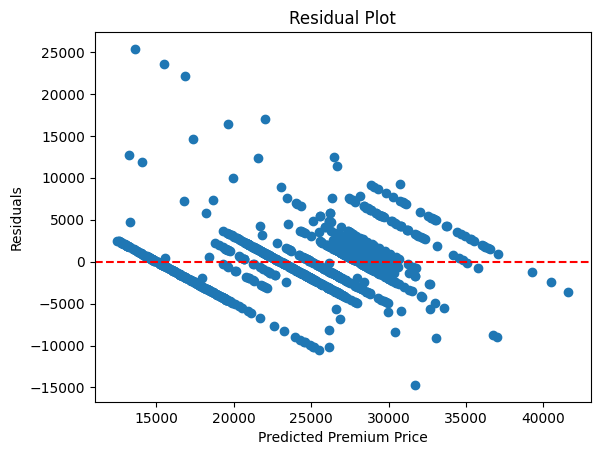

In [ ]:
residuals = model.resid
plt.scatter(model.predict(X), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Premium Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [ ]:
coeff_df = pd.DataFrame({
    'feature': model.params.index,
    'coefficient': model.params.values,
    'p-val': model.pvalues,
    'is_significant': model.pvalues < alpha
}).sort_values(by='p-val').reset_index(drop=True)

display(coeff_df)

,feature,coefficient,p-val,is_significant
0,age_squared,-6.142026,9.592781e-17,True
1,age,676.857565,3.333924e-13,True
2,any_transplants,8215.247950,9.117708e-12,True
3,diabetes,-2868.541361,2.879490e-08,True
4,known_allergies,-2453.792578,2.947802e-06,True
5,age_bmi_interaction,6.320034,1.371019e-05,True
6,blood_pressure_problems,-2181.163507,3.700383e-05,True
7,health_score,2416.296610,1.454965e-03,True
8,bmi_category,788.849687,8.296332e-03,True
9,overall_risk_category,-614.283281,6.970478e-02,False


# ML Modelling

## Data Preprocessing

### Handling Missing Values and Feature Engineering

In [ ]:
df = read_data()

def handle_missing_values(df):
  df_imputed = df.copy()

  for col in binary_cols:
    df_imputed[col] = df_imputed[col].astype(float)


  imputer = IterativeImputer(
      estimator = RandomForestRegressor(n_estimators = 50,
                                        random_state = 42),
      max_iter=10,
      random_state=69
  )

  df_imputed = pd.DataFrame(imputer.fit_transform(df_imputed), columns=df.columns)
  for col in binary_cols:
    df_imputed[col] = (df_imputed[col] >= 0.7).astype(int)

  # Add the new features for the filled values
  df_imputed = create_features(df_imputed)
  df_imputed['age_group'] = df_imputed['age_group'].astype(int)

  return df_imputed


binary_cols = ['diabetes', 'blood_pressure_problems', 'any_transplants',
               'any_chronic_diseases', 'known_allergies',
               'history_of_cancer_in_family']

df = handle_missing_values(df)
df.head()

,age,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,height,weight,known_allergies,history_of_cancer_in_family,number_of_major_surgeries,premium_price,bmi,age_group,health_score,age_health_surgery,surgery_per_age,age_bmi_interaction,bmi_health_interaction,age_squared,overall_risk_category,bmi_category,high_cost_condition,metabolic_syndrome_proxy,risk_density
0,45.0,0,0,0,0,155.0,57.0,0,0,0.0,25000.0,23.73,3,0,0.0,0.00,1067.85,0.00,2025.0,low,normal,0,0,0.000000
1,60.0,1,0,0,0,180.0,73.0,0,0,0.0,29000.0,22.53,5,1,0.0,0.00,1351.80,22.53,3600.0,low,normal,0,0,0.016667
2,36.0,1,1,0,0,158.0,59.0,0,0,1.0,23000.0,23.63,3,2,72.0,0.03,850.68,47.26,1296.0,low,normal,0,0,0.055556
3,52.0,1,1,0,1,183.0,93.0,0,0,2.0,28000.0,27.77,4,3,312.0,0.04,1444.04,83.31,2704.0,high,overweight,0,0,0.057692
4,38.0,0,0,0,1,166.0,88.0,0,0,1.0,23000.0,31.93,3,1,38.0,0.03,1213.34,31.93,1444.0,low,obese,0,0,0.026316


### Scaling and Encoding

In [ ]:
# Ordinal Encoding

def handle_ordinal_encoding(columns_list, categories_list):
  encoder = OrdinalEncoder(categories=categories_list)
  df[columns_list] = encoder.fit_transform(df[columns_list])
  return df

df = handle_ordinal_encoding(['overall_risk_category', 'bmi_category'],
                             [['low', 'medium', 'high', 'critical'],
                              ['underweight', 'normal', 'overweight', 'obese']])

df.head()

,age,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,height,weight,known_allergies,history_of_cancer_in_family,number_of_major_surgeries,premium_price,bmi,age_group,health_score,age_health_surgery,surgery_per_age,age_bmi_interaction,bmi_health_interaction,age_squared,overall_risk_category,bmi_category,high_cost_condition,metabolic_syndrome_proxy,risk_density
0,45.0,0,0,0,0,155.0,57.0,0,0,0.0,25000.0,23.73,3,0,0.0,0.00,1067.85,0.00,2025.0,0.0,1.0,0,0,0.000000
1,60.0,1,0,0,0,180.0,73.0,0,0,0.0,29000.0,22.53,5,1,0.0,0.00,1351.80,22.53,3600.0,0.0,1.0,0,0,0.016667
2,36.0,1,1,0,0,158.0,59.0,0,0,1.0,23000.0,23.63,3,2,72.0,0.03,850.68,47.26,1296.0,0.0,1.0,0,0,0.055556
3,52.0,1,1,0,1,183.0,93.0,0,0,2.0,28000.0,27.77,4,3,312.0,0.04,1444.04,83.31,2704.0,2.0,2.0,0,0,0.057692
4,38.0,0,0,0,1,166.0,88.0,0,0,1.0,23000.0,31.93,3,1,38.0,0.03,1213.34,31.93,1444.0,0.0,3.0,0,0,0.026316


In [ ]:
# Only numeric values needs to be scaled over here

def handle_feature_scaling(df, numeric_cols):
  scaler = StandardScaler()
  df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

  return df

numeric_cols = ['age', 'height', 'weight', 'number_of_major_surgeries',
                'bmi', 'age_health_surgery',
                'surgery_per_age', 'age_bmi_interaction',
                'bmi_health_interaction', 'age_squared',
                'risk_density']

df_scaled = handle_feature_scaling(df, numeric_cols)
df_scaled.head()

,age,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,height,weight,known_allergies,history_of_cancer_in_family,number_of_major_surgeries,premium_price,bmi,age_group,health_score,age_health_surgery,surgery_per_age,age_bmi_interaction,bmi_health_interaction,age_squared,overall_risk_category,bmi_category,high_cost_condition,metabolic_syndrome_proxy,risk_density
0,0.233197,0,0,0,0,-1.306105,-1.399250,0,0,-0.891187,25000.0,-0.634915,3,0,-0.660492,-0.918641,-0.165382,-1.396470,0.073874,0.0,1.0,0,0,-1.269629
1,1.307981,1,0,0,0,1.170852,-0.277062,0,0,-0.891187,29000.0,-0.839142,5,1,-0.660492,-0.918641,0.460243,-0.606914,1.402990,0.0,1.0,0,0,-0.704142
2,-0.411674,1,1,0,0,-1.008870,-1.258976,0,0,0.444239,23000.0,-0.651934,3,2,0.147908,0.849310,-0.643871,0.259740,-0.541317,0.0,1.0,0,0,0.615329
3,0.734763,1,1,0,1,1.468086,1.125674,0,0,1.779665,28000.0,0.052650,4,3,2.842574,1.438627,0.663475,1.523099,0.646871,2.0,2.0,0,0,0.687827
4,-0.268369,0,0,0,1,-0.216244,0.774990,0,0,0.444239,23000.0,0.760638,3,1,-0.233836,0.849310,0.155175,-0.277495,-0.416422,0.0,3.0,0,0,-0.376754


## Model Selection and Evaluation

In [ ]:
X = df.drop(columns=['premium_price'])
# X = X[['age_bmi_interaction', 'age', 'age_squared', 'any_transplants', 'weight', 'any_chronic_diseases']]
y = df['premium_price']

seed_value = 69
kfold = kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=seed_value),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=seed_value),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=seed_value),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=seed_value)
}

results = []
fitted_models = {}

for name, model in models.items():
    preds = cross_val_predict(model, X, y, cv=kf)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)

    errors = y - preds
    mean_err = np.mean(errors)
    se = stats.sem(errors)
    ci_low, ci_high = stats.t.interval(0.95,
                                       len(errors)-1,
                                       loc=mean_err,
                                       scale=se)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "CI_low": ci_low,
        "CI_high": ci_high
    })

    model.fit(X, y)
    fitted_models[name] = model

results_df = pd.DataFrame(results)
results_df

,Model,RMSE,MAE,R2,CI_low,CI_high
0,Linear Regression,3542.134878,2419.161024,0.678291,-196.302987,246.640254
1,Decision Tree,3889.315473,1147.058824,0.612136,-327.306724,158.949726
2,Random Forest,2858.160570,1249.137931,0.790538,-240.605862,116.731622
3,Gradient Boosting,3109.071145,1724.890627,0.752147,-231.548684,157.222064
4,XGBoost,3039.566467,1509.542584,0.763105,-231.778553,148.292360


## Interpretability and Explainability

In [ ]:
import shap
from sklearn.inspection import permutation_importance

best_model_name = results_df.sort_values("RMSE").iloc[0]["Model"]
best_model = fitted_models[best_model_name]

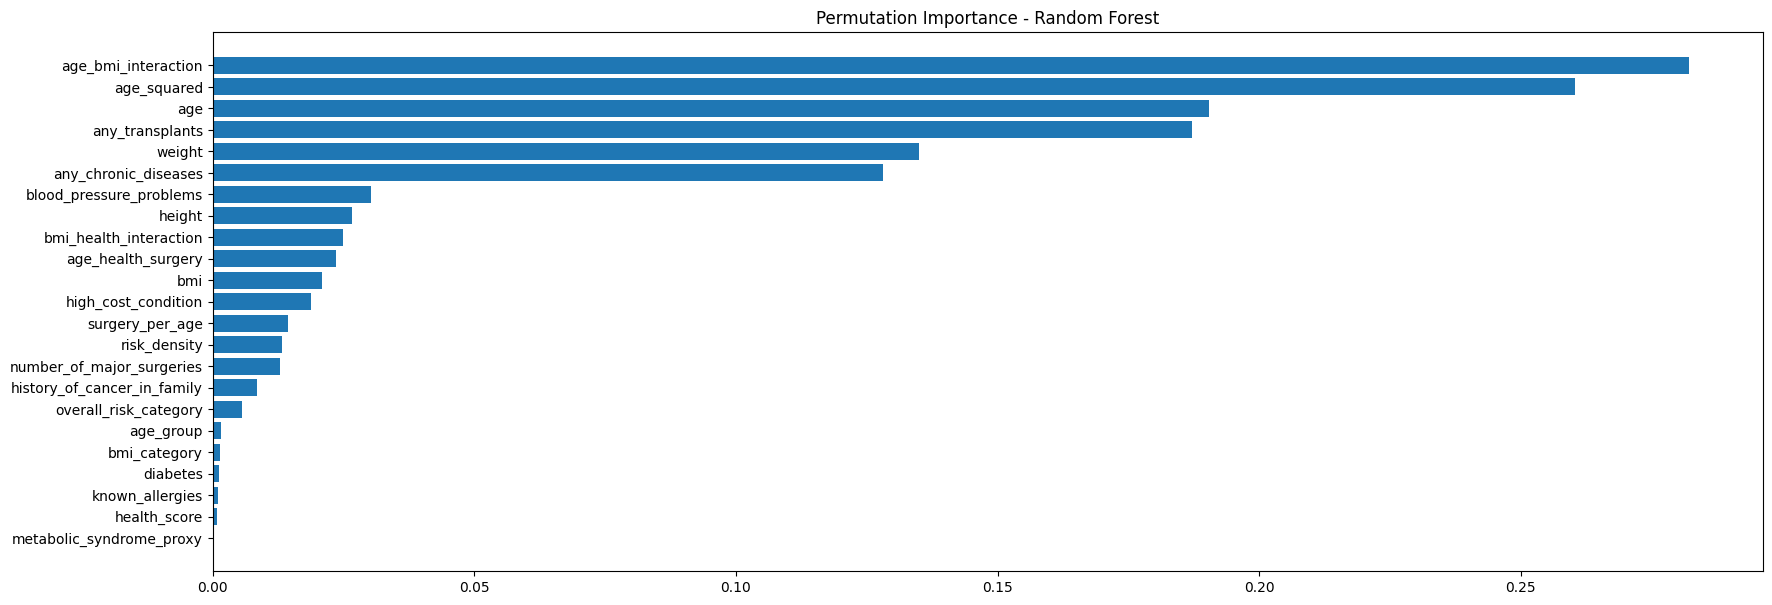

In [ ]:
# Permuatation Importance
# This tell how much each feature contributes to prediction

perm_importance = permutation_importance(best_model, X, y, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(20, 7))
plt.barh(perm_df["Feature"], perm_df["Importance"])
plt.gca().invert_yaxis()
plt.title(f"Permutation Importance - {best_model_name}")
plt.show()

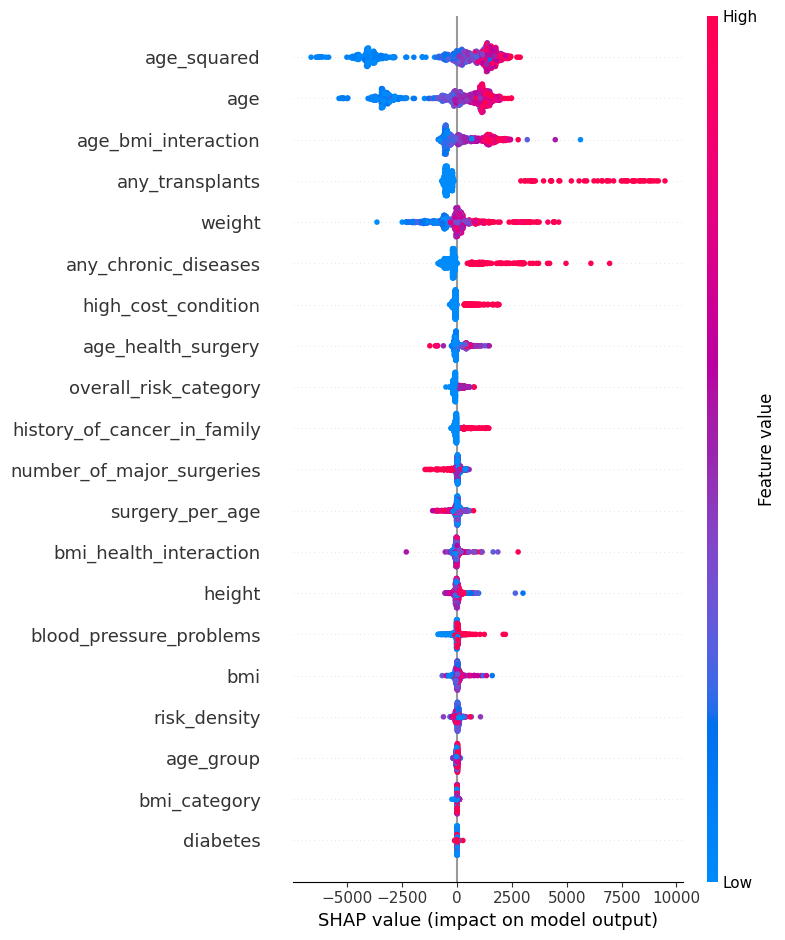

In [ ]:
# SHAP
# Shows the positive and negative effect and magnitude
# of each features influence

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

# Saving best model

In [ ]:
import pickle

with open('insurance_cost_prediction_best_model_rf.pkl', 'wb') as pkl_file:
  pickle.dump(fitted_models['Random Forest'], pkl_file)